In [1]:
%matplotlib inline
%load_ext watermark
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import pandas as pd
import numpy as np
import scipy as sp
import sklearn
import sys
from tqdm import tqdm
import nltk
import seaborn as sns
from nlp_id.stopword import StopWord
from nlp_id.lemmatizer import Lemmatizer
from nlp_id.tokenizer import PhraseTokenizer
from nlp_id.postag import PosTag
from nltk.stem import WordNetLemmatizer
from nltk.stem import WordNetLemmatizer as lemm, SnowballStemmer as stemm
from nltk.stem.porter import *
from nltk.corpus import stopwords
import gensim
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import ldamodel
from gensim.models.ldamodel import LdaModel
from gensim.models import Phrases
import gensim.corpora;
from gensim.corpora.dictionary import Dictionary
from gensim import corpora, models
from gensim.utils import simple_preprocess
import pyLDAvis.gensim; pyLDAvis.enable_notebook()
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.decomposition import LatentDirichletAllocation
from statsmodels.tsa.stattools import grangercausalitytests
from operator import itemgetter
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.utils import check_random_state
from sklearn.decomposition._online_lda_fast import _dirichlet_expectation_2d
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from keras.layers import Dense, LSTM
import pyLDAvis.sklearn
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, StopWordRemover, ArrayDictionary
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import pickle, string, re, time, os, io
from pprint import pprint
import base64
from io import BytesIO
import warnings
warnings.filterwarnings('ignore')
sns.set_context('poster')

%watermark -a 'Hanif' -d -t -v -p numpy,pandas,matplotlib,plotly,gensim,nltk,sklearn,nlp_id,keras,tensorflow
print("Num of GPUs available: ", len(tf.test.gpu_device_name()))

Using TensorFlow backend.


Hanif 2021-09-08 07:36:25 

CPython 3.6.5
IPython 7.16.1

numpy 1.18.5
pandas 0.23.4
matplotlib 2.2.3
plotly 5.2.2
gensim 4.0.1
nltk 3.4.5
sklearn 0.0
nlp_id 0.1.12.0
keras 2.3.1
tensorflow 2.1.0
Num of GPUs available:  0


In [2]:
!pip list

Package                  Version  
------------------------ ---------
absl-py                  0.13.0   
argon2-cffi              20.1.0   
asn1crypto               0.24.0   
astor                    0.8.1    
async-generator          1.10     
atomicwrites             1.4.0    
attrs                    21.2.0   
backcall                 0.2.0    
bleach                   4.1.0    
blis                     0.4.1    
cached-property          1.5.2    
cachetools               4.2.2    
catalogue                1.0.0    
certifi                  2018.4.16
cffi                     1.13.2   
chardet                  3.0.4    
charset-normalizer       2.0.4    
click                    7.1.2    
colorama                 0.4.4    
conda                    4.5.4    
contextvars              2.4      
cryptography             2.2.2    
cycler                   0.10.0   
cymem                    2.0.5    
Cython                   0.29.21  
cytoolz                  0.9.0.1  
dataclasses         

You are using pip version 10.0.1, however version 21.2.4 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [3]:
# # Loading the data
start = time.time()
data = pd.read_csv(r"D:\dataset\covid.csv", error_bad_lines=True)
print(start)
print(data)

1631061393.9794374
      conversation_id       date      time       user_id         username  \
0        1.280000e+18   7/7/2020  23:52:02  7.913021e+07          jpnncom   
1        1.280000e+18   7/7/2020  23:50:35  9.490000e+17    kabarrakyatid   
2        1.280000e+18   7/7/2020  23:46:02  7.913021e+07          jpnncom   
3        1.280000e+18   7/7/2020  23:45:37  1.280000e+18       antar_news   
4        1.280000e+18   7/7/2020  23:36:03  4.564266e+08    merdekadotcom   
5        1.280000e+18   7/7/2020  23:32:10  1.754497e+08        acengmumu   
6        1.280000e+18   7/7/2020  23:32:06  1.260000e+18       azu_kazuka   
7        1.280000e+18   7/7/2020  23:31:27  1.050000e+18      poeticgloss   
8        1.280000e+18   7/7/2020  23:22:09  8.310505e+07    vobochachayee   
9        1.280000e+18   7/7/2020  23:16:16  1.250000e+18           tarxte   
10       1.280000e+18   7/7/2020  23:14:31  1.020000e+18       andreptrss   
11       1.280000e+18   7/7/2020  23:06:17  7.930000e+17 

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9285 entries, 0 to 9284
Data columns (total 11 columns):
conversation_id    9285 non-null float64
date               9285 non-null object
time               9285 non-null object
user_id            9285 non-null float64
username           9285 non-null object
tweet              9285 non-null object
mentions           9285 non-null object
replies_count      9285 non-null int64
retweets_count     9285 non-null int64
likes_count        9285 non-null int64
hashtags           9285 non-null object
dtypes: float64(2), int64(3), object(6)
memory usage: 798.0+ KB


In [5]:
list_tweet = list(data.tweet)

In [6]:
list_tweet

['Sandiaga Uno mengungkapkan pihaknya bersama EP For Jokowi berkomitmen tinggi untuk membantu pemerintah dalam upaya memutus mata rantai penyebaran COVID-19 lewat rapid test. #rapidtestcorona https://m.jpnn.com/news/sandiaga-uno-gelar-rapid-test-di-sarinah-bersama-sukarelawan-ep-jokowi\xa0…',
 'Pemerintah Jawa Timur Kolaborasi dengan Kedutaan Inggris Mengatasi\xa0Covid-19  https://kabarrakyat.id/pemerintah-jawa-timur-kolaborasi-dengan-kedutaan-inggris-mengatasi-covid-19/\xa0…',
 'Anggota Komisi IV DPR RI, Andi Akmal Pasluddin menilai Pemerintah belum cukup turun tangan pada penyelamatan kehidupan petani di masa pandemi covid-19 yang hingga saat ini masih berlangsung.  #DPRRI https://m.jpnn.com/news/andi-akmal-dpr-pemerintah-belum-efektif-selamatkan-nasib-petani-di-masa-pandemi\xa0…',
 '"Warga Kota Juang (Bireuen) yang terkonfirmasi positif terinfeksi virus corona itu dirilis sebagai pasien 88 COVID-19 Aceh," ujar Juru Bicara Gugus Tugas Percepatan Penanganan COVID-19 Pemerintah Aceh, S

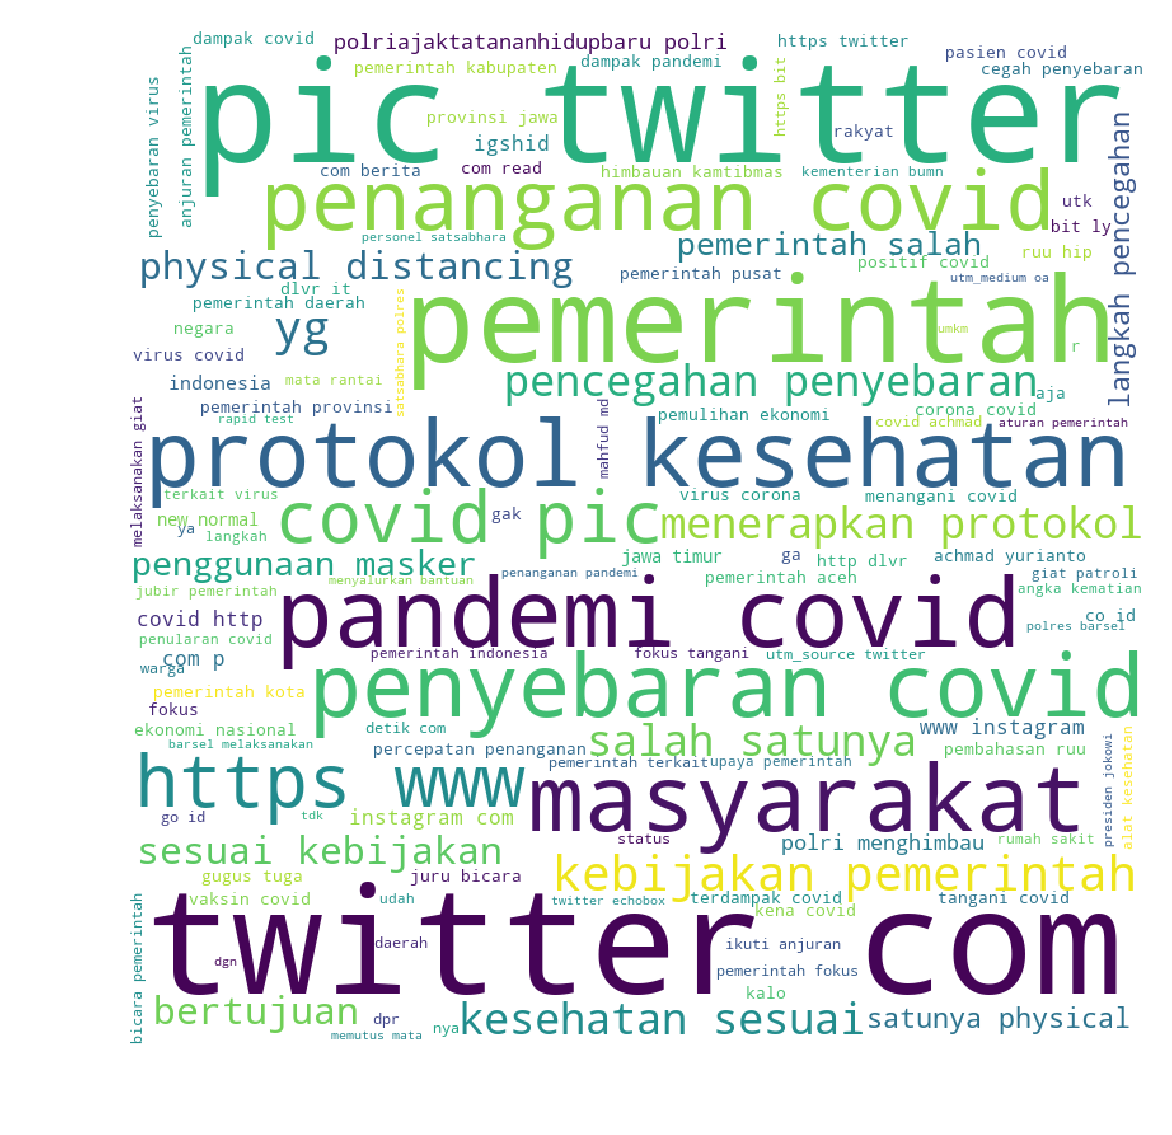

In [7]:
comment_words = ''
stops = set(stopwords.words('indonesian')) #NLTK
 
# iterate through the csv file
for val in data.tweet:
     
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = val.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stops,
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

In [8]:
print(stopwords.words('indonesian'))

['ada', 'adalah', 'adanya', 'adapun', 'agak', 'agaknya', 'agar', 'akan', 'akankah', 'akhir', 'akhiri', 'akhirnya', 'aku', 'akulah', 'amat', 'amatlah', 'anda', 'andalah', 'antar', 'antara', 'antaranya', 'apa', 'apaan', 'apabila', 'apakah', 'apalagi', 'apatah', 'artinya', 'asal', 'asalkan', 'atas', 'atau', 'ataukah', 'ataupun', 'awal', 'awalnya', 'bagai', 'bagaikan', 'bagaimana', 'bagaimanakah', 'bagaimanapun', 'bagi', 'bagian', 'bahkan', 'bahwa', 'bahwasanya', 'baik', 'bakal', 'bakalan', 'balik', 'banyak', 'bapak', 'baru', 'bawah', 'beberapa', 'begini', 'beginian', 'beginikah', 'beginilah', 'begitu', 'begitukah', 'begitulah', 'begitupun', 'bekerja', 'belakang', 'belakangan', 'belum', 'belumlah', 'benar', 'benarkah', 'benarlah', 'berada', 'berakhir', 'berakhirlah', 'berakhirnya', 'berapa', 'berapakah', 'berapalah', 'berapapun', 'berarti', 'berawal', 'berbagai', 'berdatangan', 'beri', 'berikan', 'berikut', 'berikutnya', 'berjumlah', 'berkali-kali', 'berkata', 'berkehendak', 'berkeinginan'

In [9]:
#We only need the Headlines_text column from the data
data_text = data[['tweet']]
datanggal = data[['date']]
data_tgl = np.unique(np.array([ii[:10] for ii in datanggal['date']]))
print(data_text)
print(data_tgl)

                                                  tweet
0     Sandiaga Uno mengungkapkan pihaknya bersama EP...
1     Pemerintah Jawa Timur Kolaborasi dengan Keduta...
2     Anggota Komisi IV DPR RI, Andi Akmal Pasluddin...
3     "Warga Kota Juang (Bireuen) yang terkonfirmasi...
4     Meski Kembali Zona Kuning Covid-19, Pemkot Kla...
5     kesadaran masyarakat yang masih rendah salah a...
6     Bagaimana jika sebenarnya angka kematian dan p...
7     Pak @Jokowi Pandemi COVID-19 telah merenggut n...
8     wkwkwk kayaknya konspirasi soal covid yg ak ta...
9     kamu kira pemerintah mau gitu bikin event offl...
10    Paling juga orang-orang udah pada angkat tanga...
11    Binmas Polda Diy - Sambang berikan himbauan ke...
12    BISA BERHENTI KYK GINI GAK??? 😭 @ pemerintah t...
13    Ketua MPR Minta Pemerintah Buat Standarisasi H...
14    Kodim 0205/TK bekerja sama dengan instansi ter...
15    Perawatan Penderita Covid-19 Tak Murah, Pemeri...
16    BANSOS covid-19 buat warga menengah ke baw

In [10]:
# We need to remove stopwords first. Casting all values to float will make it easier to iterate over.
data_text = data_text.astype('str')
print(data_text)

                                                  tweet
0     Sandiaga Uno mengungkapkan pihaknya bersama EP...
1     Pemerintah Jawa Timur Kolaborasi dengan Keduta...
2     Anggota Komisi IV DPR RI, Andi Akmal Pasluddin...
3     "Warga Kota Juang (Bireuen) yang terkonfirmasi...
4     Meski Kembali Zona Kuning Covid-19, Pemkot Kla...
5     kesadaran masyarakat yang masih rendah salah a...
6     Bagaimana jika sebenarnya angka kematian dan p...
7     Pak @Jokowi Pandemi COVID-19 telah merenggut n...
8     wkwkwk kayaknya konspirasi soal covid yg ak ta...
9     kamu kira pemerintah mau gitu bikin event offl...
10    Paling juga orang-orang udah pada angkat tanga...
11    Binmas Polda Diy - Sambang berikan himbauan ke...
12    BISA BERHENTI KYK GINI GAK??? 😭 @ pemerintah t...
13    Ketua MPR Minta Pemerintah Buat Standarisasi H...
14    Kodim 0205/TK bekerja sama dengan instansi ter...
15    Perawatan Penderita Covid-19 Tak Murah, Pemeri...
16    BANSOS covid-19 buat warga menengah ke baw

In [11]:
for idx in range(len(data_text)):
    listing = []
    #go through each word in each data_text row, remove stopwords, and set them on the index.
    for word in data_text.iloc[idx]['tweet'].split(' '):
        if "http" not in word:
            if "@" not in word:
                if "#" not in word:                        
                    if word not in stopwords.words('indonesian'):
                        if word.isalpha():
                            if len(word) > 2:
                                listing.append(word)
    data_text.iloc[idx]['tweet'] = listing
    #print logs to monitor output
    if idx % 100 == 0:
        sys.stdout.write('\rc = ' + str(idx) + ' / ' + str(len(data_text)));

print(data_text)

c = 9200 / 9285                                                  tweet
0     [Sandiaga, Uno, For, Jokowi, berkomitmen, memb...
1     [Pemerintah, Jawa, Timur, Kolaborasi, Kedutaan...
2     [Anggota, Komisi, DPR, Andi, Akmal, Pasluddin,...
3     [Kota, Juang, terkonfirmasi, positif, terinfek...
4     [Meski, Kembali, Zona, Kuning, Pemkot, Klaim, ...
5     [kesadaran, masyarakat, rendah, salah, atu, pe...
6     [Bagaimana, angka, kematian, penularan, covid,...
7     [Pak, Pandemi, merenggut, nyawa, Pemerintah, D...
8     [wkwkwk, kayaknya, konspirasi, covid, tau, klo...
9     [pemerintah, gitu, bikin, event, offline, even...
10    [Paling, udah, angkat, tangan, ngikutin, perke...
11    [Binmas, Polda, Diy, Sambang, himbauan, karyaw...
12    [BISA, BERHENTI, KYK, GINI, pemerintah, tolong...
13    [Ketua, MPR, Minta, Pemerintah, Buat, Standari...
14    [Kodim, instansi, terkait, Kepolisian, Pemerin...
15    [Perawatan, Penderita, Tak, Pemerintah, Minta,...
16    [BANSOS, warga, menengah, j

In [12]:
#save data because it takes very long to remove stop words
pickle.dump(data_text, open('data_text.dat', 'wb'))

In [13]:
#get the words as an array for LDA input
train_komen = [value[0] for value in data_text.iloc[0:].values];
print('train_komen',train_komen)
print(len(train_komen))

train_komen [['Sandiaga', 'Uno', 'For', 'Jokowi', 'berkomitmen', 'membantu', 'pemerintah', 'upaya', 'memutus', 'mata', 'rantai', 'penyebaran', 'rapid'], ['Pemerintah', 'Jawa', 'Timur', 'Kolaborasi', 'Kedutaan', 'Inggris'], ['Anggota', 'Komisi', 'DPR', 'Andi', 'Akmal', 'Pasluddin', 'menilai', 'Pemerintah', 'turun', 'tangan', 'penyelamatan', 'kehidupan', 'petani', 'pandemi'], ['Kota', 'Juang', 'terkonfirmasi', 'positif', 'terinfeksi', 'virus', 'corona', 'dirilis', 'pasien', 'Juru', 'Bicara', 'Gugus', 'Tugas', 'Percepatan', 'Penanganan', 'Pemerintah'], ['Meski', 'Kembali', 'Zona', 'Kuning', 'Pemkot', 'Klaim', 'Pagaralam', 'Aman', 'Pemerintah', 'Kota', 'Sumatera', 'membuka', 'dunia', 'pariwisata', 'era', 'new', 'Meski', 'berstatus', 'zona', 'kuning', 'wisata', 'kota'], ['kesadaran', 'masyarakat', 'rendah', 'salah', 'atu', 'penyebabnya', 'kebijakn', 'pemerintah', 'abu', 'abu', 'melawan', 'membiarkannya'], ['Bagaimana', 'angka', 'kematian', 'penularan', 'covid', 'indonesia', 'dunia', 'tekan'

In [14]:
# Create Bigram & Trigram Models
bigram = gensim.models.Phrases(train_komen, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[train_komen], threshold=100)

for idx in range(len(train_komen)):
    for token in bigram[train_komen[idx]]:
        if '_' in token:
            # token is a bigram, add to document.
            train_komen[idx].append(token)
    for token in trigram[train_komen[idx]]:
        if '_' in token:
            train_komen[idx].append(token)

In [15]:
train_komen

[['Sandiaga',
  'Uno',
  'For',
  'Jokowi',
  'berkomitmen',
  'membantu',
  'pemerintah',
  'upaya',
  'memutus',
  'mata',
  'rantai',
  'penyebaran',
  'rapid',
  'memutus_mata',
  'memutus_mata',
  'memutus_mata'],
 ['Pemerintah', 'Jawa', 'Timur', 'Kolaborasi', 'Kedutaan', 'Inggris'],
 ['Anggota',
  'Komisi',
  'DPR',
  'Andi',
  'Akmal',
  'Pasluddin',
  'menilai',
  'Pemerintah',
  'turun',
  'tangan',
  'penyelamatan',
  'kehidupan',
  'petani',
  'pandemi',
  'Anggota_Komisi',
  'Anggota_Komisi',
  'Anggota_Komisi'],
 ['Kota',
  'Juang',
  'terkonfirmasi',
  'positif',
  'terinfeksi',
  'virus',
  'corona',
  'dirilis',
  'pasien',
  'Juru',
  'Bicara',
  'Gugus',
  'Tugas',
  'Percepatan',
  'Penanganan',
  'Pemerintah',
  'Juru_Bicara',
  'Gugus_Tugas',
  'Juru_Bicara',
  'Gugus_Tugas',
  'Juru_Bicara',
  'Gugus_Tugas'],
 ['Meski',
  'Kembali',
  'Zona',
  'Kuning',
  'Pemkot',
  'Klaim',
  'Pagaralam',
  'Aman',
  'Pemerintah',
  'Kota',
  'Sumatera',
  'membuka',
  'dunia',

In [16]:
## membuat dictionary dari text
dictionary = gensim.corpora.Dictionary(train_komen)
dictionary.filter_extremes(no_below=5, no_above=0.2)
print(dictionary)

Dictionary(4019 unique tokens: ['Jokowi', 'Sandiaga', 'berkomitmen', 'mata', 'membantu']...)


In [17]:
# mengonversi corpus ke dalam bentuk dokument term matrix menggunakan dictionary
doc_term_matrix = [dictionary.doc2bow(doc) for doc in train_komen]
# convert into the bag-of-words format
print(len(doc_term_matrix))
print(doc_term_matrix[100])
tfidf = models.TfidfModel(doc_term_matrix) # build TF-IDF model
corpus_tfidf = tfidf[doc_term_matrix]
corpus_tfidf

9285
[(25, 1), (28, 1), (29, 3), (31, 1), (425, 1), (455, 1), (456, 3), (458, 1), (552, 1), (590, 1), (654, 1), (773, 1), (774, 1), (775, 1), (776, 1), (777, 3), (778, 1), (779, 1), (780, 1)]


In [18]:
doc_term_matrix

[[(0, 1),
  (1, 1),
  (2, 1),
  (3, 1),
  (4, 1),
  (5, 1),
  (6, 3),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1)],
 [(11, 1), (12, 1), (13, 1), (14, 1)],
 [(15, 1),
  (16, 3),
  (17, 1),
  (18, 1),
  (19, 1),
  (20, 1),
  (21, 1),
  (22, 1),
  (23, 1),
  (24, 1)],
 [(25, 1),
  (26, 1),
  (27, 3),
  (28, 1),
  (29, 3),
  (30, 1),
  (31, 1),
  (32, 1),
  (33, 1),
  (34, 1),
  (35, 1),
  (36, 1),
  (37, 1),
  (38, 1),
  (39, 1),
  (40, 1)],
 [(30, 1),
  (41, 1),
  (42, 1),
  (43, 1),
  (44, 2),
  (45, 1),
  (46, 1),
  (47, 1),
  (48, 1),
  (49, 1),
  (50, 1),
  (51, 1),
  (52, 1),
  (53, 1),
  (54, 1),
  (55, 1),
  (56, 1),
  (57, 1),
  (58, 2)],
 [(59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1)],
 [(49, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1)],
 [(17, 1),
  (72, 1),
  (73, 1),
  (74, 1),
  (75, 1),
  (76, 1),
  (77, 1),
  (78, 1),
  (79, 1),
  (80, 2),
  (81, 1),
  (82, 1),
  (83, 1),
  (84, 2),
  (85, 1)],
 [(67, 1), (86, 1), (87, 1), (88, 1), (89, 1), (90, 1

In [19]:
dict_corpus = {}

for i in range(len(corpus_tfidf)):
  for idx, freq in corpus_tfidf[i]:
    if dictionary[idx] in dict_corpus:
      dict_corpus[dictionary[idx]] += freq
    else:
       dict_corpus[dictionary[idx]] = freq
       
dict_df = pd.DataFrame.from_dict(dict_corpus, orient='index', columns=['freq'])

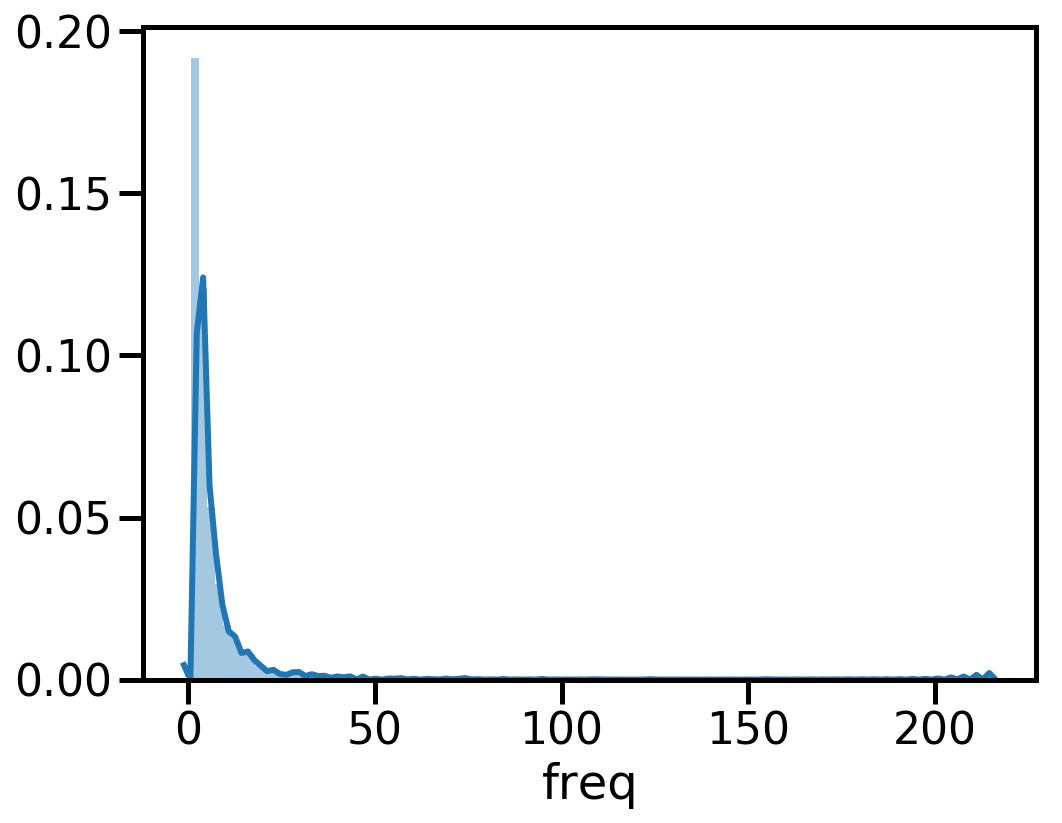

In [20]:
plt.figure(figsize=(8,6))
sns.distplot(dict_df['freq'], bins=100)

In [21]:
dict_df.sort_values('freq', ascending=False).head(10)

freq
masyarakat  214.277309
kesehatan   212.426722
protokol    210.870923
salah       210.827530
penyebaran  210.533450
kebijakan   209.572025
langkah     207.759293
pencegahan  207.316265
sesuai      206.740891
satunya     206.029159

In [22]:
extension = dict_df[dict_df.freq>213].index.tolist()

In [23]:
extension

['masyarakat']

In [24]:
ids=[dictionary.token2id[extension[i]] for i in range(len(extension))]
dictionary.filter_tokens(bad_ids=ids)

In [25]:
print('Total Vocabulary Size:', len(dictionary))

Total Vocabulary Size: 4018


In [26]:
# Create Corpus: Term Document Frequency
corpus = [dictionary.doc2bow(text) for text in train_komen]

In [27]:
print(len(corpus))
print(corpus[100])
tfidf = models.TfidfModel(corpus) # build TF-IDF model
corpus_tfidf = tfidf[corpus]
corpus_tfidf

9285
[(25, 1), (28, 1), (29, 3), (31, 1), (424, 1), (454, 1), (455, 3), (457, 1), (551, 1), (589, 1), (653, 1), (772, 1), (773, 1), (774, 1), (775, 1), (776, 3), (777, 1), (778, 1), (779, 1)]


In [28]:
#kelompokkan komentar berdasar tanggal
harian = []
for tgl in data_tgl:
    harini = [train_komen[ii] for ii in range(len(datanggal)) if datanggal.iloc[ii]['date'][:10] == tgl]
    harian.append(harini)
    print(len(harini))

703
706
745
809
639
1174
788
761
1171
1789


In [29]:
#number of topics we will cluster for: 5
num_topics = 10

In [30]:
# # LDA
# For LDA, we need to obtain a design matrix. To improve results, I am going to apply TfIdf transformation to the counts.

#the count vectorizer needs string inputs, not array, so I join them with a space.
#train_headlines_sentences = [' '.join(text) for text in train_headlines]
train_headlines_sentens = [[' '.join(text) for text in harini] for harini in harian]
print('\n','train_headlines_sentences',train_headlines_sentens)


 train_headlines_sentences [['Pak DPR pemerintah fokus penanganan covid membahas Cukup corona membahas_Cukup membahas_Cukup membahas_Cukup', 'Defisit Anggaran APBN Pengusaha Muslim Setelah Pemerintah mengumumkan anggaran triliun Maret Juni pemerintah menaikkan triliun peningkatan stimulus Defisit_Anggaran APBN_Pengusaha Muslim_Setelah Defisit_Anggaran APBN_Pengusaha Defisit_Anggaran_APBN_Pengusaha Muslim_Setelah', 'Tapi emg kejadian beneran keluarga gua Adik sepupu gua meninggal karna sakit udh dicek Malah dibungkus covid tes ulang adaan udh meninggal tetep negatif maksa jadiin covid Karena pemerintah', 'Pak Pandemi merenggut nyawa Pemerintah DPR fokus tangani rutin bahas Omnibus Law merenggut_nyawa tangani_rutin bahas_Omnibus tangani_rutin merenggut_nyawa tangani_rutin_bahas_Omnibus', 'Pembagian Masker Face Shield Menuju Adaptasi Kebiasaan Hidup Baru Pasar Templek Kota memutus mata rantai penyebaran Polri TNI Pemerintah Kota Face_Shield Adaptasi_Kebiasaan memutus_mata Adaptasi_Kebias

In [31]:
#get the words as an array for LDA input
lda = ldamodel.LdaModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=num_topics);

In [32]:
def get_lda_topics(model, num_topics):
    word_dict = {}
    for i in range(num_topics):
        words = model.show_topic(i, topn = 10);
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = [i[0] for i in words]
    return pd.DataFrame(word_dict)

In [33]:
get_lda_topics(lda, num_topics)

Topic # 01          Topic # 02        Topic # 03  \
0  Pemulihan_Ekonomi         Gugus_Tugas     tangani_rutin   
1         penanganan   Pemulihan_Ekonomi   merenggut_nyawa   
2            pandemi  Protokol_Kesehatan             fokus   
3       Surat_Edaran          Penanganan           tangani   
4               Jawa    sembuh_meninggal               Pak   
5            ekonomi               Tugas             bahas   
6          Pemulihan             percaya             bebas   
7            Ekonomi               Gugus  biaya_pengobatan   
8        gugus_tugas              Komite             nyawa   
9             dampak               salah               DPR   

           Topic # 04                  Topic # 05  Topic # 06  \
0      memakai_masker                       covid     satunya   
1  kamtibmas_mematuhi          adaptasi_kebiasaan  distancing   
2  Memerangi_tanggung                        kalo    physical   
3               orang                 DKI_Jakarta  penggunaan   
4   melaksanakan_giat                 Juru_Bicara    protokol   
5            himbauan                  rapid_test  menerapkan   
6      sambangi_warga  Memperhatikan_perkembangan  pencegahan   
7               cegah       mendorong_pertumbuhan  Menghimbau   
8              Vaksin                         aja       salah   
9       ikuti_anjuran                     pandemi     langkah   

              Topic # 07       Topic # 08  Topic # 09       Topic # 10  
0                   Aceh      rumah_sakit       covid  Achmad_Yurianto  
1          Presiden_Joko            covid        Jawa      Juru_Bicara  
2                RUU_HIP  Presiden_Jokowi  biar_dapet            covid  
3                   Joko            sakit  penanganan     memutus_mata  
4      berupaya_maksimal             kena      vaksin           Achmad  
5               Presiden            rumah         gak      Gugus_Tugas  
6                 Widodo        Indonesia      pasien         Yurianto  
7             penanganan  Achmad_Yurianto    kenaikan       new_normal  
8     Mahasiswa_Penerima          pandemi       usaha       Penanganan  
9  Widodo_menandatangani       New_Normal       pusat              Ini

In [34]:
def get_lda_topics(lda, n_top_words):
    
    #the word ids obtained need to be reverse-mapped to the words so we can print the topic names.
    feat_names = vectorizer.get_feature_names()
    #print('\n feat names')
    #print(feat_names
    word_dict = {}
    for i in range(num_topics):
        #for each topic, obtain the largest values, and add the words they map to into the dictionary.
        words_ids = model.components_[i].argsort()[:-n_top_words - 1:-1]
        words = [feat_names[key] for key in words_ids]
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = words
        
    return pd.DataFrame(word_dict)

In [35]:
feedback = []
for y, santens in enumerate(train_headlines_sentens):
    # Now, we obtain a Counts design matrix, for which we use SKLearn’s CountVectorizer module. The transformation will return a matrix of size (Documents x Features), where the value of a cell is going to be the number of times the feature (word) appears in that document.
    # To reduce the size of the matrix, to speed up computation, we will set the maximum feature size to 5000, which will take the top 5000 best features that can contribute to our model.
    vectorizer = CountVectorizer(analyzer='word', ngram_range=(2, 3), max_features=5000)
    x_coints = vectorizer.fit_transform(santens)
    transformer = TfidfTransformer(smooth_idf=False)
    x_tfidf = transformer.fit_transform(x_coints)
    xtfidf_norm = normalize(x_tfidf, norm='l1', axis=1)
    model = LatentDirichletAllocation(n_components=num_topics, learning_method='online')
    model.fit(xtfidf_norm)
    toPik = get_lda_topics(lda, 7)
    print('tanggal',data_tgl[y])
    print('\n','konsep matrix \n',toPik)
    feedback.append(toPik)

tanggal 7/15/2020

 konsep matrix 
                        Topic # 01                           Topic # 02  \
0                    dampak covid                     pemerintah cegah   
1                  faktor ekonomi  pemerintah mengejarnya memperbanyak   
2  dukung_sepenuhnya bumi_pertiwi               pemerintah mengejarnya   
3              thread bahas covid                    karena pemerintah   
4                    thread bahas          pemerintah cegah penyebaran   
5                    ikuti arahan                     cegah penyebaran   
6            pemerintah soal masa                     penyebaran covid   

                    Topic # 03                      Topic # 04  \
0          salahkan pemerintah            kondisi perekonomian   
1                   kena covid  kebijakan pemerintah menangani   
2                    mau covid            kebijakan pemerintah   
3        pemerintah masyarakat                wacana perubahan   
4  pemerintah serius menangani    wacana 

In [36]:
model.fit(x_coints)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=10, n_jobs=None,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=0)

In [37]:
x_coints.shape

(1789, 5000)

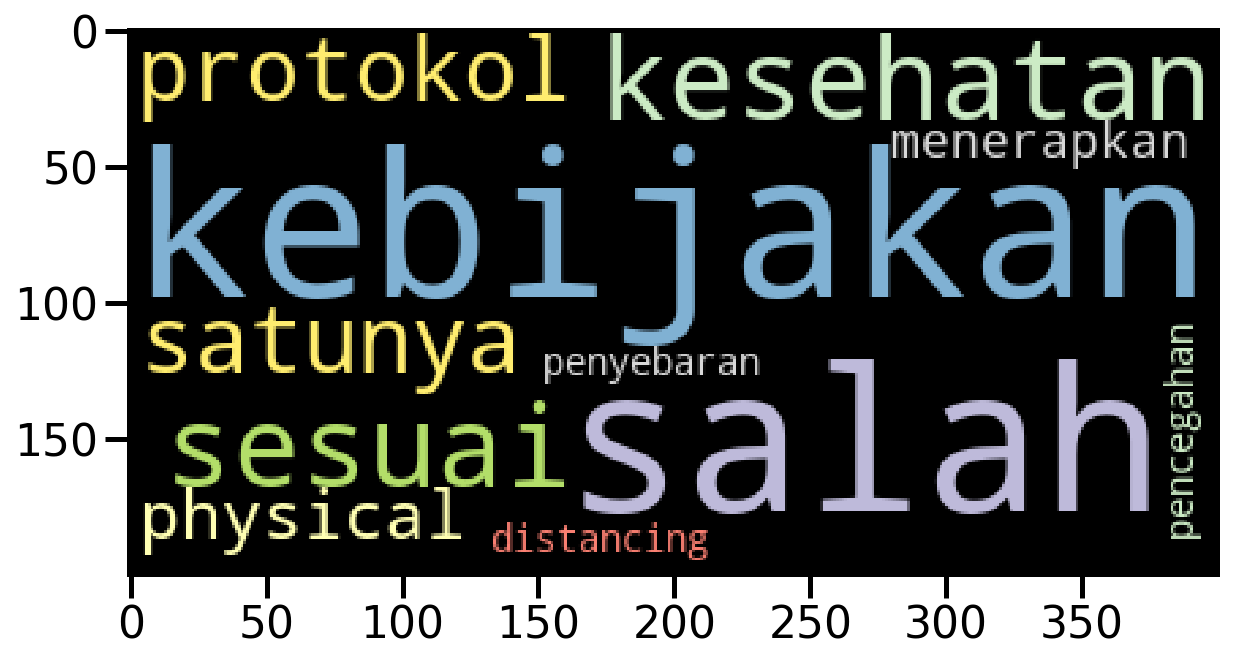

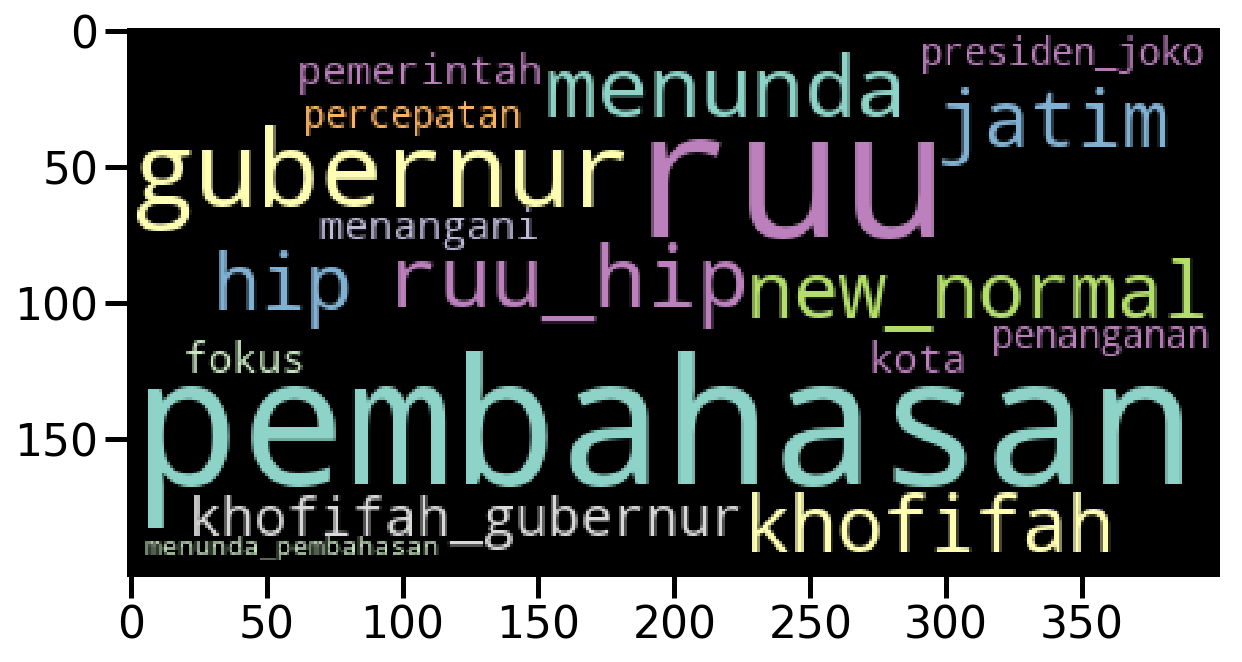

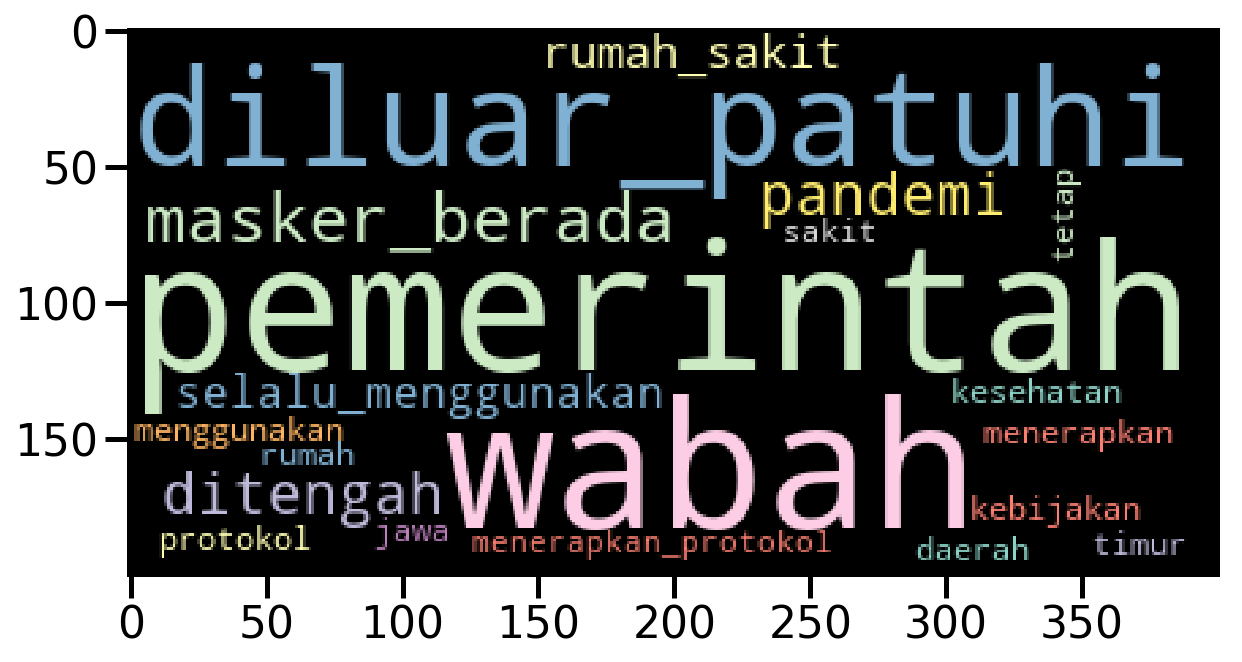

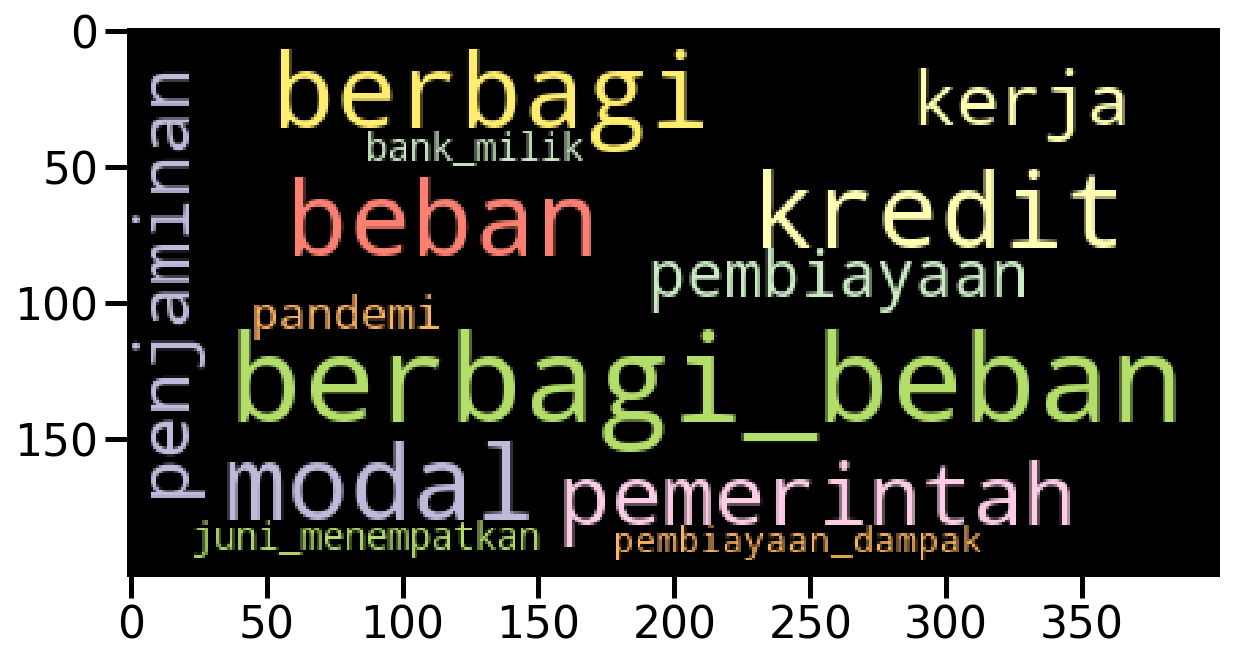

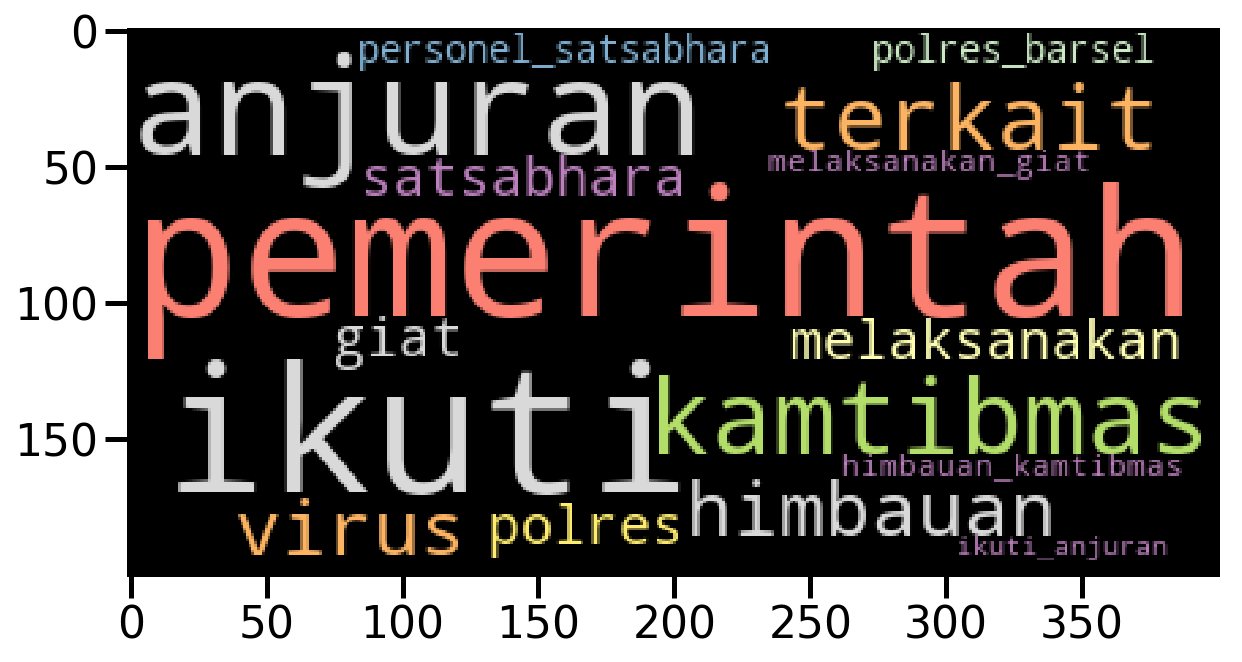

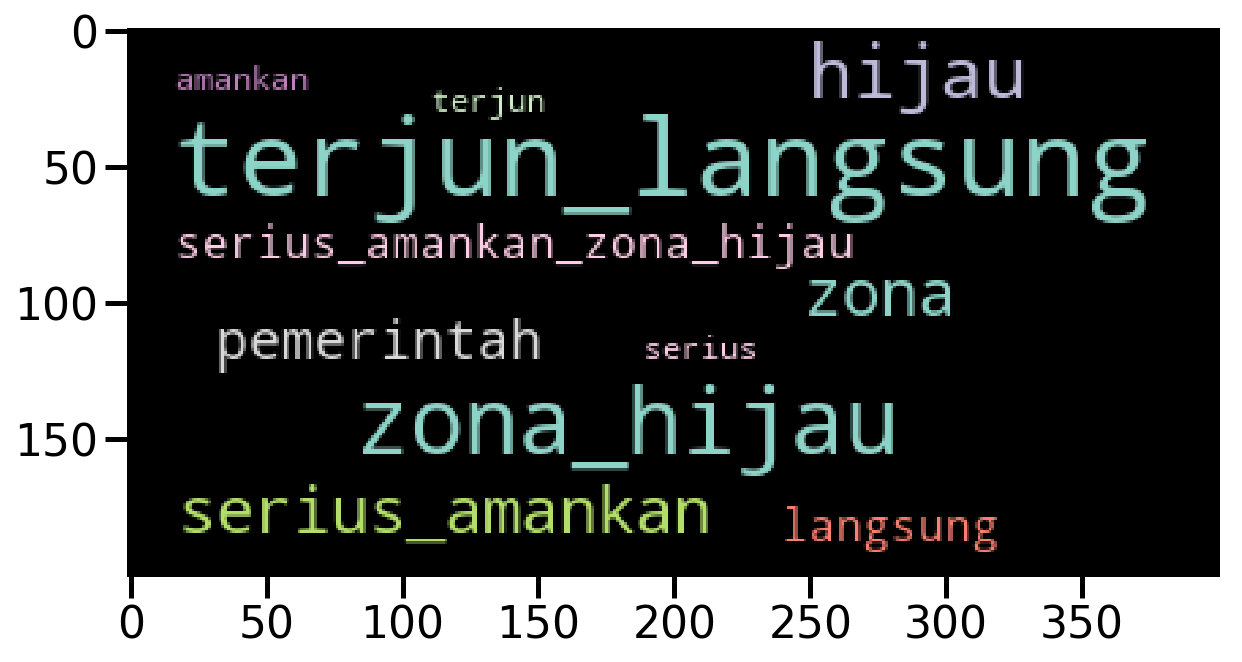

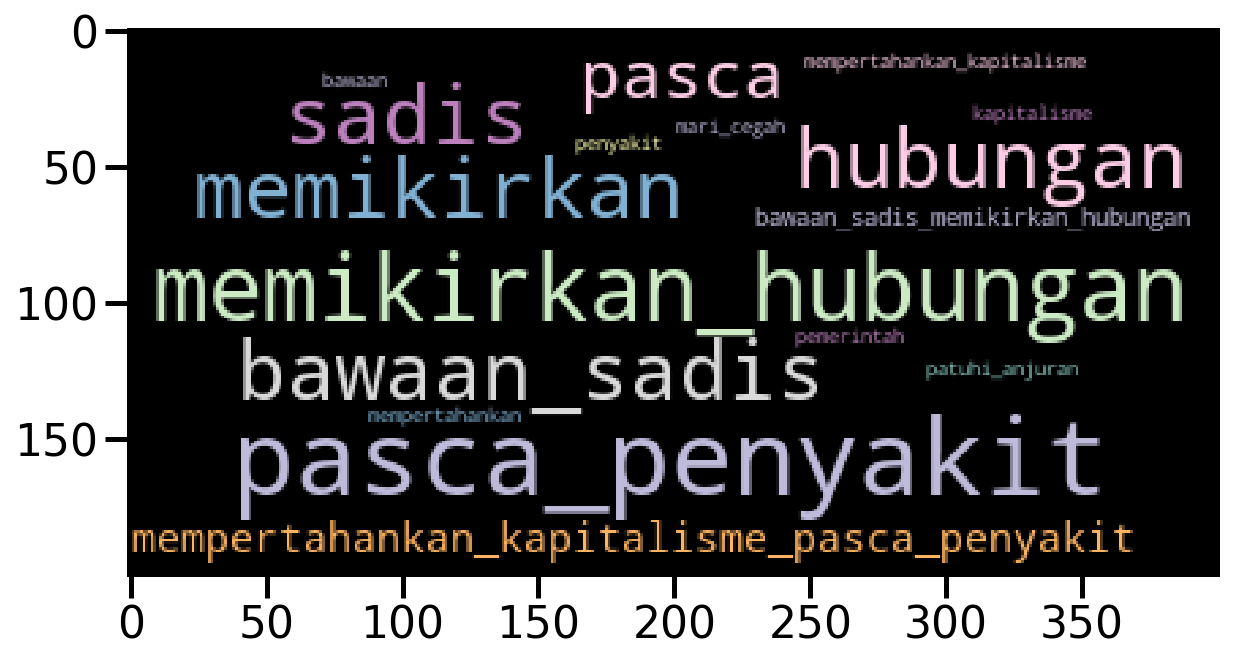

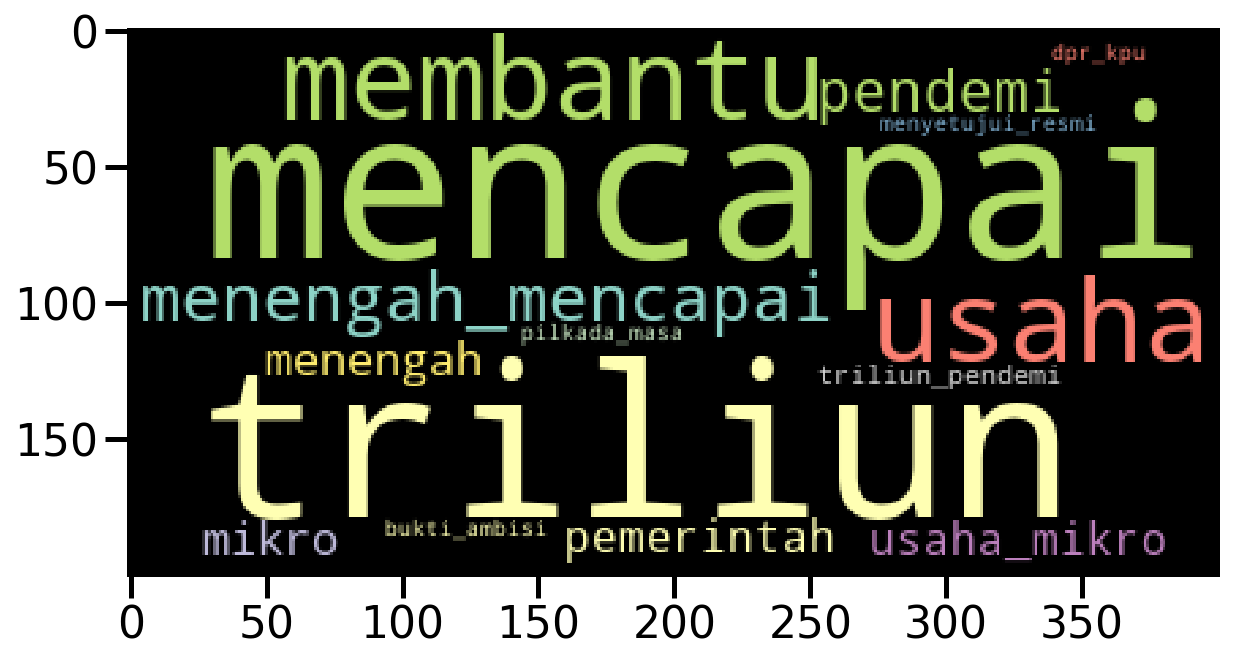

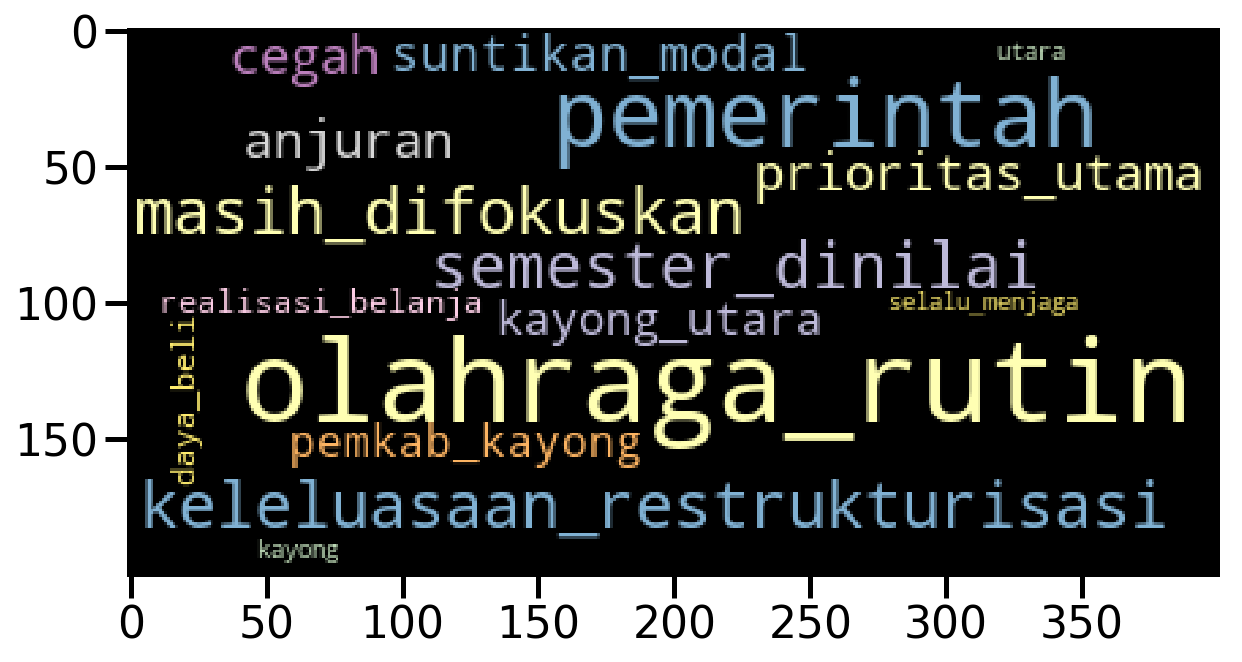

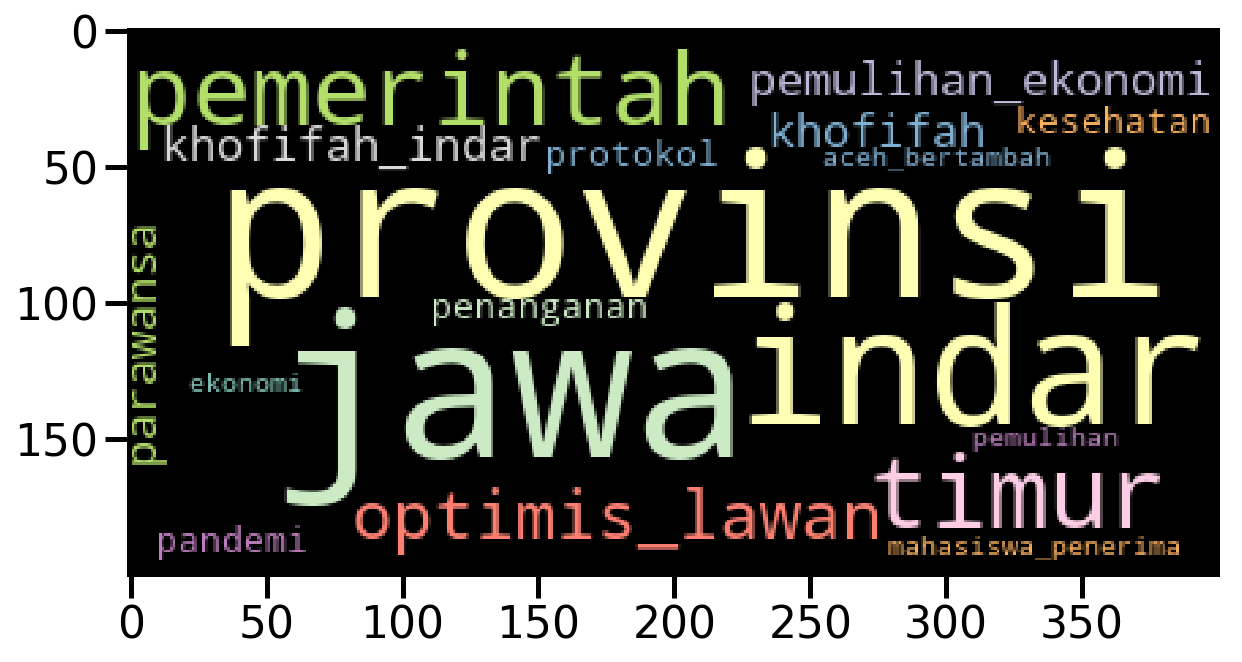

In [38]:
for index, topic in enumerate(model.components_):
    tmps = [vectorizer.get_feature_names()[i] for i in topic.argsort()[-15:]]
    teks = " ".join(str(topik) for topik in tmps)
    wcloud = WordCloud(max_words=50, colormap='Set3', background_color='black').generate(teks)
    plt.figure(figsize=(10,5))
    plt.imshow(wcloud)
    plt.show()

In [39]:
topic_model = ldamodel.LdaModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=10, iterations=200) 

In [40]:
# each element of the list is a tuple 
# containing the topic and word / probability list
topics = topic_model.show_topics(num_words = 7, formatted = False)
topics

[(0,
  [('satunya', 0.023050403),
   ('physical', 0.022957804),
   ('penggunaan', 0.022793986),
   ('distancing', 0.022696203),
   ('sesuai', 0.022566015),
   ('menerapkan', 0.022454182),
   ('salah', 0.022333603)]),
 (1,
  [('new_normal', 0.009371714),
   ('Presiden_Joko', 0.009357835),
   ('RUU_HIP', 0.008566861),
   ('pandemi', 0.0074475436),
   ('Joko', 0.0069842576),
   ('fokus', 0.006947109),
   ('covid', 0.0068406337)]),
 (2,
  [('orang', 0.01278219),
   ('bertahan', 0.008971781),
   ('Penanganan', 0.0072559146),
   ('Jawa', 0.00721554),
   ('Provinsi', 0.006658419),
   ('BUMN_sinergi', 0.0061829207),
   ('Besar', 0.0060592135)]),
 (3,
  [('Pemulihan_Ekonomi', 0.0310098),
   ('covid', 0.010863879),
   ('Pemulihan', 0.010656715),
   ('Ekonomi', 0.010359041),
   ('Surat_Edaran', 0.008853486),
   ('ekonomi', 0.008398273),
   ('pandemi', 0.008194241)]),
 (4,
  [('Gugus_Tugas', 0.020321539),
   ('memakai_masker', 0.015564524),
   ('kamtibmas_mematuhi', 0.013182278),
   ('memutus_mata

In [41]:
%%time
lda_model = gensim.models.LdaModel(corpus=corpus_tfidf, id2word=dictionary,
                                   chunksize=1740, alpha='auto',
                                   eta='auto', random_state=42,
                                   iterations=500, num_topics=10,
                                   passes=20, eval_every=None)

Wall time: 56.9 s


In [42]:
#Viewing the topics in our trained topic model
for topic_id, topic in lda_model.print_topics(num_topics=10, num_words=7):
    print('Topic #'+str(topic_id+1)+':')
    print(topic)
    print()

Topic #1:
0.022*"pandemi" + 0.017*"penanganan" + 0.013*"ekonomi" + 0.011*"Pandemi" + 0.011*"Indonesia" + 0.010*"menangani" + 0.010*"virus"

Topic #2:
0.026*"RUU_HIP" + 0.018*"RUU" + 0.014*"Surat_Edaran" + 0.013*"HIP" + 0.012*"Pembahasan_RUU" + 0.011*"Manajemen_Krisis" + 0.011*"Aceh_Buat"

Topic #3:
0.017*"Memerangi_tanggung" + 0.012*"mendorong_pertumbuhan" + 0.011*"Memperhatikan_perkembangan" + 0.010*"tanggung" + 0.009*"mendorong" + 0.009*"Tapi" + 0.009*"Atasi_Dampak"

Topic #4:
0.025*"covid" + 0.015*"pasien" + 0.012*"orang" + 0.012*"positif" + 0.011*"Penanganan" + 0.011*"aja" + 0.011*"Covid"

Topic #5:
0.029*"Gugus_Tugas" + 0.027*"Achmad_Yurianto" + 0.022*"Juru_Bicara" + 0.017*"new_normal" + 0.011*"Gugus" + 0.011*"anjuran" + 0.011*"Tugas"

Topic #6:
0.045*"protokol" + 0.042*"kesehatan" + 0.042*"salah" + 0.041*"pencegahan" + 0.040*"kebijakan" + 0.040*"sesuai" + 0.040*"langkah"

Topic #7:
0.011*"DKI_Jakarta" + 0.010*"Presiden_Joko" + 0.009*"tangani_rutin" + 0.009*"merenggut_nyawa" + 0.0

In [43]:
#viewing the overall mean coherence score of the model
topics_coherences = lda_model.top_topics(corpus_tfidf, topn=20)
avg_coherence_score = np.mean([item[1] for item in topics_coherences])
print('Avg. Coherence Score:', avg_coherence_score)

Avg. Coherence Score: -14.388134498467906


In [44]:
#looking at the output of our LDA topic model
topics_with_wts = [item[0] for item in topics_coherences]
print('LDA Topics with Weights')
print('='*50)
for idx, topic in enumerate(topics_with_wts):
    print('Topic #'+str(idx+1)+':')
    print([(term, round(wt, 3)) for wt, term in topic])
    print()

LDA Topics with Weights
Topic #1:
[('pandemi', 0.022), ('penanganan', 0.017), ('ekonomi', 0.013), ('Pandemi', 0.011), ('Indonesia', 0.011), ('menangani', 0.01), ('virus', 0.01), ('fokus', 0.009), ('dampak', 0.008), ('warga', 0.008), ('vaksin', 0.007), ('anggaran', 0.007), ('terdampak', 0.007), ('membantu', 0.007), ('bantuan', 0.007), ('Juli', 0.006), ('covid', 0.006), ('Protokol_Kesehatan', 0.006), ('upaya', 0.006), ('corona', 0.006)]

Topic #2:
[('covid', 0.025), ('pasien', 0.015), ('orang', 0.012), ('positif', 0.012), ('Penanganan', 0.011), ('aja', 0.011), ('Covid', 0.011), ('gak', 0.01), ('rumah_sakit', 0.009), ('kalo', 0.009), ('data', 0.008), ('percaya', 0.008), ('Jawa', 0.008), ('utk', 0.007), ('Kabupaten', 0.007), ('rumah', 0.007), ('kena', 0.007), ('angka', 0.007), ('Corona', 0.007), ('Jatim', 0.006)]

Topic #3:
[('protokol', 0.045), ('kesehatan', 0.042), ('salah', 0.042), ('pencegahan', 0.041), ('kebijakan', 0.04), ('sesuai', 0.04), ('langkah', 0.04), ('menerapkan', 0.04), ('s

In [45]:
model = LdaModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=10)
for idx, topic in model.print_topics():
    print('Topic: ({}) word: {}'.format(idx, topic))

Topic: (0) word: 0.009*"Memerangi_tanggung" + 0.008*"berupaya" + 0.008*"covid" + 0.008*"pasien" + 0.007*"new_normal" + 0.007*"tangani_rutin" + 0.007*"merenggut_nyawa" + 0.006*"Tidak" + 0.006*"Pandemi" + 0.006*"positif"
Topic: (1) word: 0.012*"covid" + 0.009*"DKI_Jakarta" + 0.008*"Presiden_Joko" + 0.008*"nya" + 0.008*"rapid_test" + 0.007*"pandemi" + 0.006*"Joko" + 0.006*"Jakarta" + 0.006*"penanganan" + 0.005*"Widodo"
Topic: (2) word: 0.041*"Pemulihan_Ekonomi" + 0.016*"Ekonomi" + 0.014*"Pemulihan" + 0.012*"sembuh_meninggal" + 0.012*"Nasional" + 0.010*"gugus_tugas" + 0.008*"Atasi_Dampak" + 0.006*"Corona" + 0.006*"penanganan" + 0.006*"Besar"
Topic: (3) word: 0.028*"Achmad_Yurianto" + 0.024*"Gugus_Tugas" + 0.018*"Juru_Bicara" + 0.017*"rumah_sakit" + 0.011*"Penanganan" + 0.010*"Yurianto" + 0.010*"Achmad" + 0.010*"percaya" + 0.009*"Gugus" + 0.009*"Tugas"
Topic: (4) word: 0.014*"Protokol_Kesehatan" + 0.013*"adaptasi_kebiasaan" + 0.012*"insentif_pajak" + 0.010*"Memperhatikan_perkembangan" + 0.0

In [46]:
#viewing the topics as a list of terms without the weights
print('LDA Topics without Weights')
print('='*50)
for idx, topic in enumerate(topics_with_wts):
    print('Topic #'+str(idx+1)+':')
    print([term for wt, term in topic])
    print()

LDA Topics without Weights
Topic #1:
['pandemi', 'penanganan', 'ekonomi', 'Pandemi', 'Indonesia', 'menangani', 'virus', 'fokus', 'dampak', 'warga', 'vaksin', 'anggaran', 'terdampak', 'membantu', 'bantuan', 'Juli', 'covid', 'Protokol_Kesehatan', 'upaya', 'corona']

Topic #2:
['covid', 'pasien', 'orang', 'positif', 'Penanganan', 'aja', 'Covid', 'gak', 'rumah_sakit', 'kalo', 'data', 'percaya', 'Jawa', 'utk', 'Kabupaten', 'rumah', 'kena', 'angka', 'Corona', 'Jatim']

Topic #3:
['protokol', 'kesehatan', 'salah', 'pencegahan', 'kebijakan', 'sesuai', 'langkah', 'menerapkan', 'satunya', 'penyebaran', 'penggunaan', 'distancing', 'bertujuan', 'physical', 'Menghimbau', 'memakai_masker', 'kamtibmas_mematuhi', 'disiplin', 'sambangi_warga', 'memakai']

Topic #4:
['Gugus_Tugas', 'Achmad_Yurianto', 'Juru_Bicara', 'new_normal', 'Gugus', 'anjuran', 'Tugas', 'melaksanakan_giat', 'Yurianto', 'Achmad', 'ikuti_anjuran', 'Juru', 'diterima_langsung', 'Bantuan_alat', 'Bicara', 'Virus', 'ikuti', 'BUMN', 'himbau

In [47]:
umass_coherence_model_lda = gensim.models.CoherenceModel(model=lda_model,
                                                         corpus=corpus_tfidf,
                                                         texts=train_komen,
                                                         dictionary=dictionary,
                                                         coherence='u_mass')
avg_coherence_umass = umass_coherence_model_lda.get_coherence()

perplexity = lda_model.log_perplexity(corpus_tfidf)

print('Avg. Coherence Score (UMass):', avg_coherence_umass)
print('Model Perplexity:', perplexity)

Avg. Coherence Score (UMass): -14.388134498467902
Model Perplexity: -8.30257156293784


In [48]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel( corpus=corpus_tfidf, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=lda_model, texts=train_komen, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [49]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus_tfidf, texts=train_komen, start=2, limit=40, step=6)

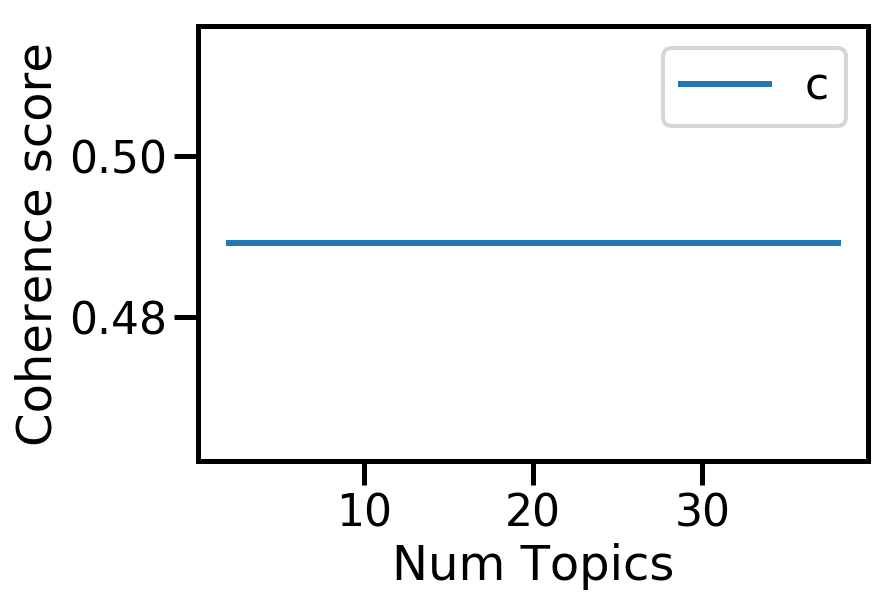

In [50]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [51]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 7))

Num Topics = 2  has Coherence Value of 0.4891749
Num Topics = 8  has Coherence Value of 0.4891749
Num Topics = 14  has Coherence Value of 0.4891749
Num Topics = 20  has Coherence Value of 0.4891749
Num Topics = 26  has Coherence Value of 0.4891749
Num Topics = 32  has Coherence Value of 0.4891749
Num Topics = 38  has Coherence Value of 0.4891749


In [52]:
LDA_viz = pyLDAvis.gensim.prepare(lda_model, corpus_tfidf, dictionary)
pyLDAvis.save_html(LDA_viz, "D:/dataset/LDA.html")

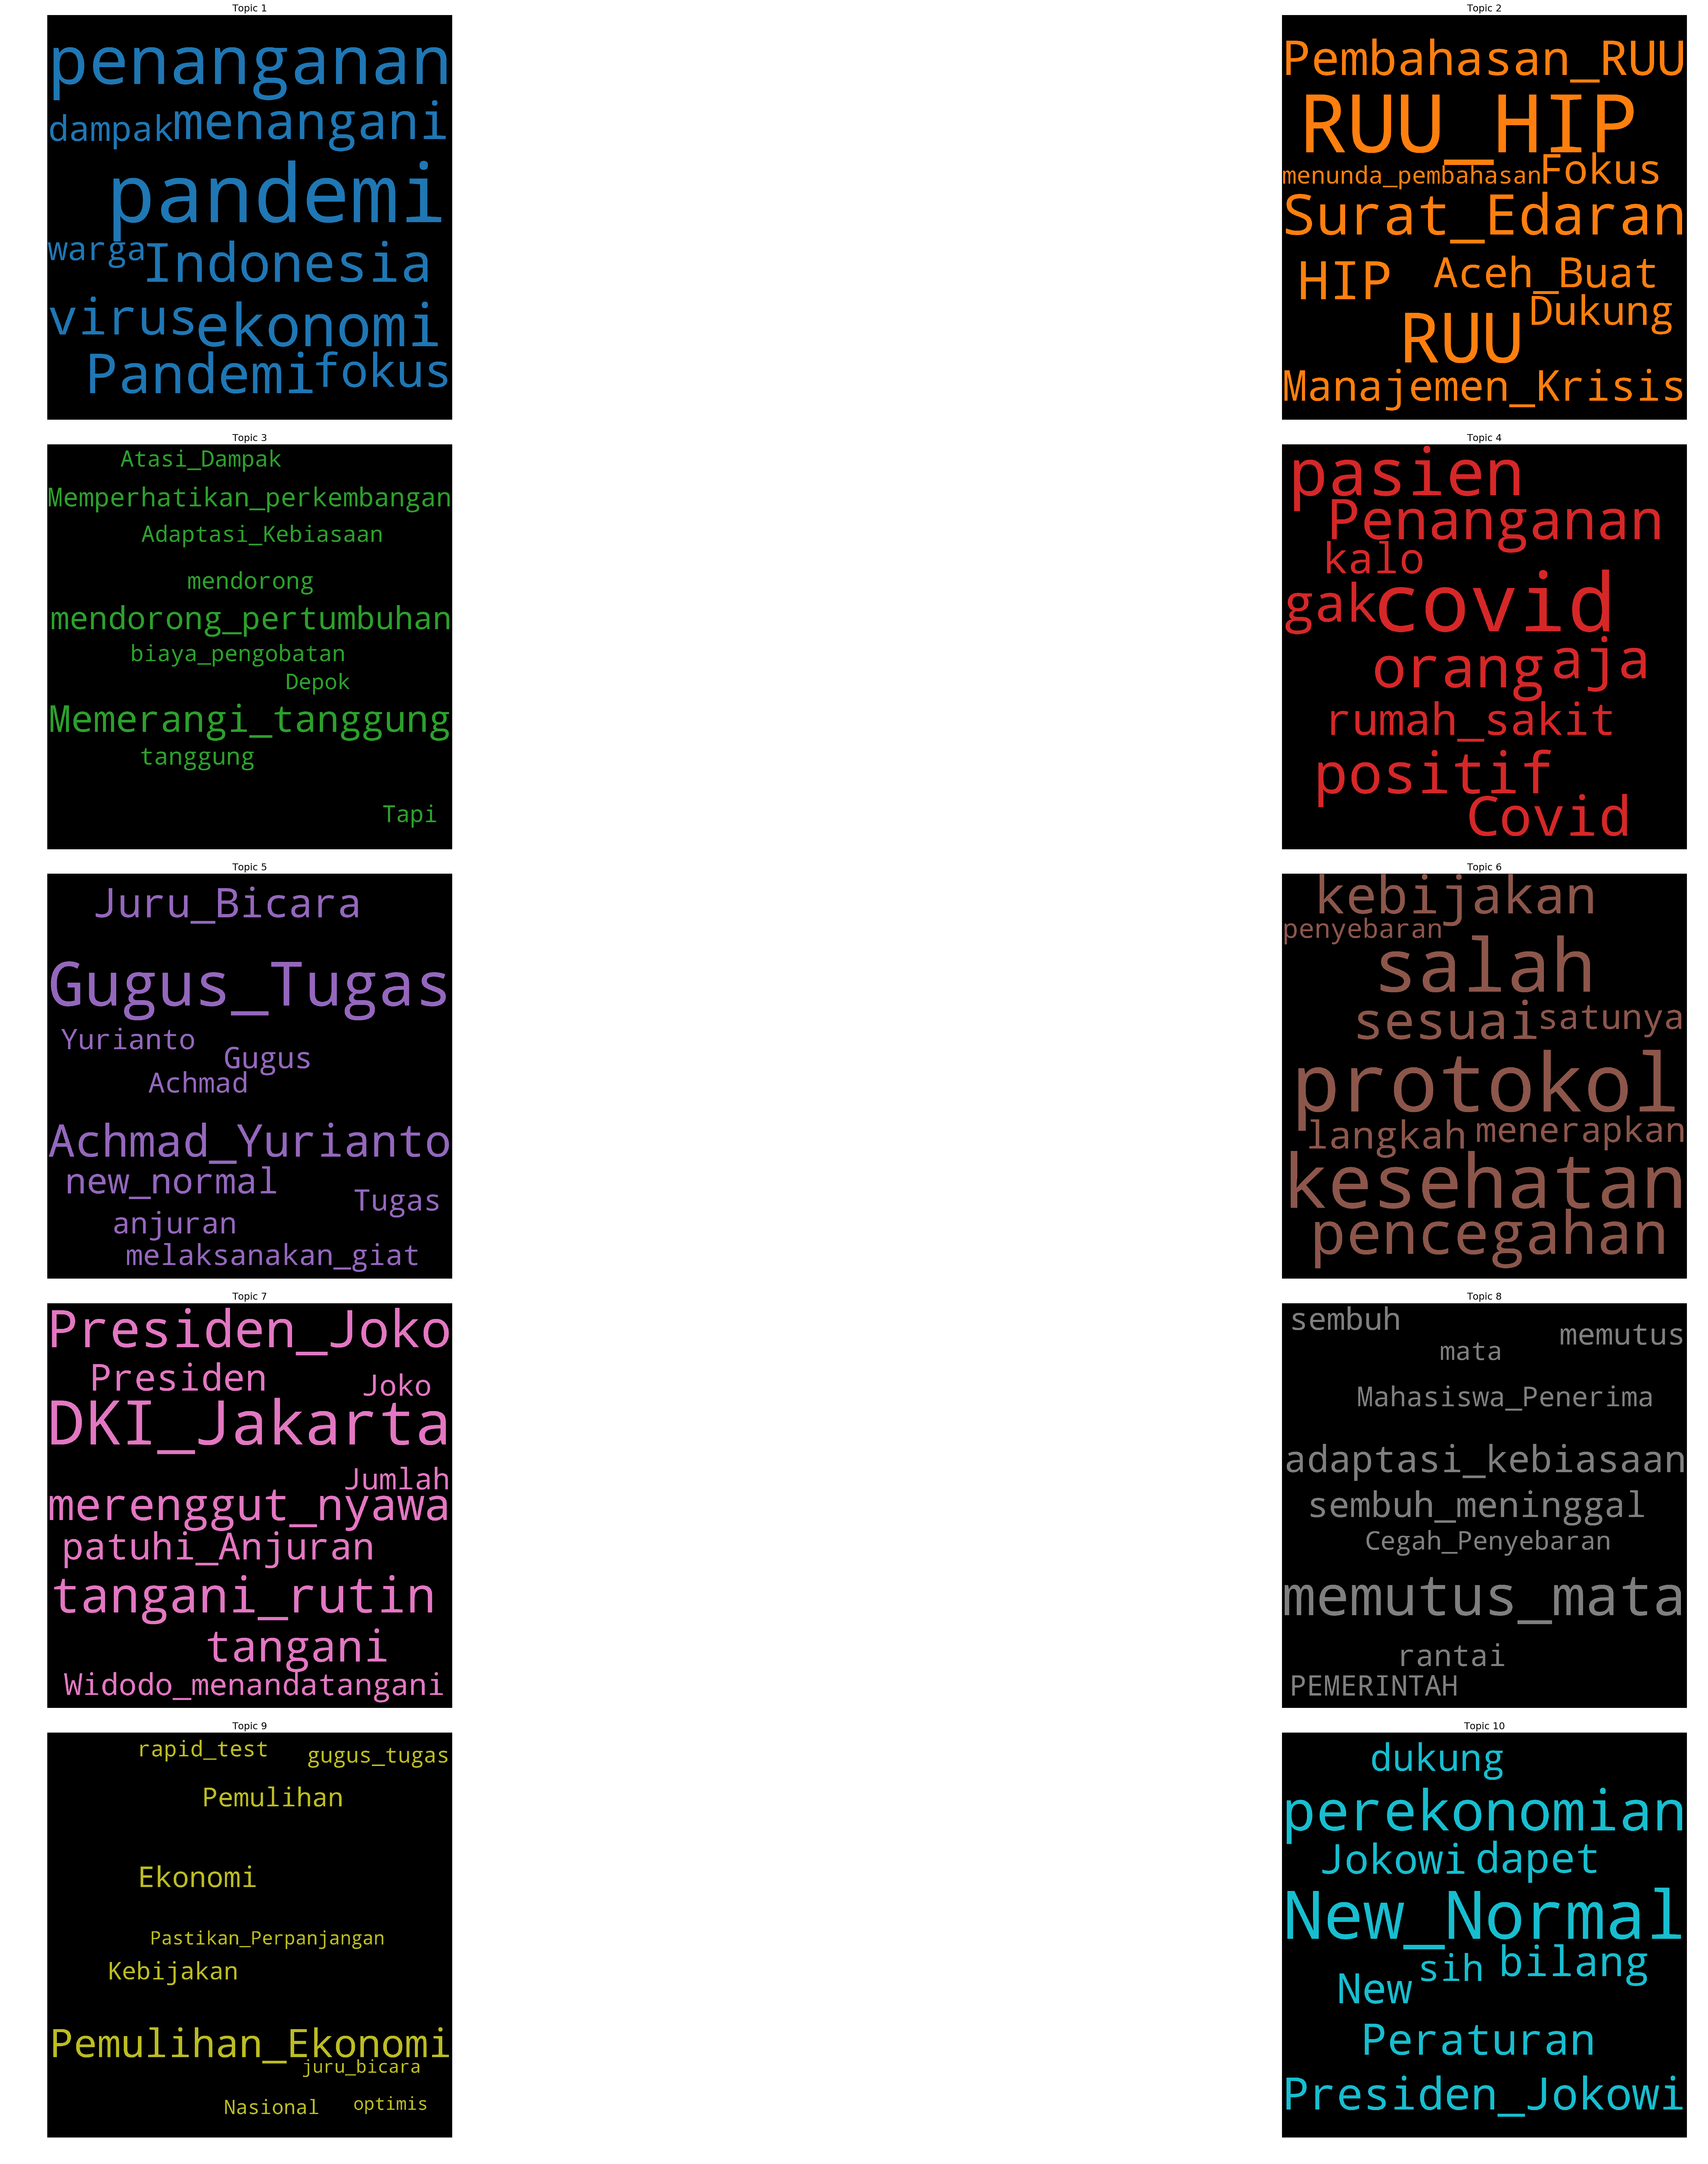

In [53]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'
cloud = WordCloud(stopwords=STOPWORDS,
                  background_color='black',
                  width=2500,
                  height=2500,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)


topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(5, 2, figsize=(80,50), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=500)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i+1), fontdict=dict(size=16))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [54]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

df_topic_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus_tfidf, texts=train_komen)

In [55]:
# Format
df_dominant_topic = df_topic_keywords.reset_index()
df_dominant_topic.columns = ['date', 'Dominant_Topic', 'Topic_Perc_Contrib','keywords', 'title']
df_dominant_topic.date = data.date

# Show
df_dominant_topic.head(10)

date  Dominant_Topic  Topic_Perc_Contrib  \
0  7/7/2020             7.0              0.2391   
1  7/7/2020             3.0              0.3174   
2  7/7/2020             0.0              0.3667   
3  7/7/2020             4.0              0.2763   
4  7/7/2020             3.0              0.2923   
5  7/7/2020             0.0              0.1870   
6  7/7/2020             0.0              0.3519   
7  7/7/2020             6.0              0.4484   
8  7/7/2020             3.0              0.3195   
9  7/7/2020             2.0              0.2145   

                                            keywords  \
0  memutus_mata, adaptasi_kebiasaan, sembuh_menin...   
1  covid, pasien, orang, positif, Penanganan, aja...   
2  pandemi, penanganan, ekonomi, Pandemi, Indones...   
3  Gugus_Tugas, Achmad_Yurianto, Juru_Bicara, new...   
4  covid, pasien, orang, positif, Penanganan, aja...   
5  pandemi, penanganan, ekonomi, Pandemi, Indones...   
6  pandemi, penanganan, ekonomi, Pandemi, Indones...   
7  DKI_Jakarta, Presiden_Joko, tangani_rutin, mer...   
8  covid, pasien, orang, positif, Penanganan, aja...   
9  Memerangi_tanggung, mendorong_pertumbuhan, Mem...   

                                               title  
0  [Sandiaga, Uno, For, Jokowi, berkomitmen, memb...  
1  [Pemerintah, Jawa, Timur, Kolaborasi, Kedutaan...  
2  [Anggota, Komisi, DPR, Andi, Akmal, Pasluddin,...  
3  [Kota, Juang, terkonfirmasi, positif, terinfek...  
4  [Meski, Kembali, Zona, Kuning, Pemkot, Klaim, ...  
5  [kesadaran, masyarakat, rendah, salah, atu, pe...  
6  [Bagaimana, angka, kematian, penularan, covid,...  
7  [Pak, Pandemi, merenggut, nyawa, Pemerintah, D...  
8  [wkwkwk, kayaknya, konspirasi, covid, tau, klo...  
9  [pemerintah, gitu, bikin, event, offline, even...

In [56]:
df_topics_keyword_sorted = pd.DataFrame()

df_topics_keyword_sorted_grouped = df_topic_keywords.groupby('Dominant_Topic')

for i, grp in df_topics_keyword_sorted_grouped:
    df_topics_keyword_sorted = pd.concat([df_topics_keyword_sorted, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
df_topics_keyword_sorted.reset_index(drop=True, inplace=True)

# Format
df_topics_keyword_sorted.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
df_topics_keyword_sorted.head()

Topic_Num  Topic_Perc_Contrib  \
0        0.0              0.5815   
1        1.0              0.5141   
2        2.0              0.4052   
3        3.0              0.5257   
4        4.0              0.5520   

                                            Keywords  \
0  pandemi, penanganan, ekonomi, Pandemi, Indones...   
1  RUU_HIP, RUU, Surat_Edaran, HIP, Pembahasan_RU...   
2  Memerangi_tanggung, mendorong_pertumbuhan, Mem...   
3  covid, pasien, orang, positif, Penanganan, aja...   
4  Gugus_Tugas, Achmad_Yurianto, Juru_Bicara, new...   

                                                Text  
0  [HIMBAUAN, rutin, Personel, Polsek, Gunung, Me...  
1  [Satgas, Aman, Nusa, Satuan, Brimob, Polda, Ke...  
2  [Memerangi, tanggung, pemerintah, tanggung, pa...  
3  [Keluarga, Pemerintah, Provinsi, Jawa, Timur, ...  
4  [Personel, Satsabhara, Polres, Barsel, melaksa...

In [57]:
temp_list = [] # A temp variable for us to form a dataframe

for x in range(df_dominant_topic.shape[0]): # For all the documents
    new_doc = train_komen[x] # Get the content of document (already preprocessed)
    new_doc_bow = dictionary.doc2bow(new_doc) # Form a BOW
    temp = lda_model.get_document_topics(new_doc_bow, minimum_probability=0.0) # Get the doc-topic dist
    temp_list.append([round(n,5) for _, n in temp]) # Add in all the probabilities

# Create Dataframe for our probabilities
doc_topic_df_prob = pd.DataFrame(temp_list)

# Get a copy of the original table containing document and their contents
df_original_copy = df_dominant_topic

# Merge the 2 dataframe together
doc_topic_table = pd.concat([df_original_copy, doc_topic_df_prob], axis=1)

# Remove certain rows for a more concise table
doc_topic_table = doc_topic_table[[col for col in doc_topic_table.columns if col not in 
                                       ['Dominant_Topic','Topic_Perc_Contrib','title']]]
# Renaming columns
doc_topic_table.rename(columns={0: "Topic 1", 1: "Topic 2", 2: "Topic 3", 3: "Topic 4", 4: "Topic 5", 5: "Topic 6", 6: "Topic 7", 7: "Topic 8", 8: "Topic 9", 9: "Topic 10"},
                       inplace=True)
# Display the table
doc_topic_table

date                                           keywords  Topic 1  \
0      7/7/2020  memutus_mata, adaptasi_kebiasaan, sembuh_menin...  0.17943   
1      7/7/2020  covid, pasien, orang, positif, Penanganan, aja...  0.23276   
2      7/7/2020  pandemi, penanganan, ekonomi, Pandemi, Indones...  0.56922   
3      7/7/2020  Gugus_Tugas, Achmad_Yurianto, Juru_Bicara, new...  0.21126   
4      7/7/2020  covid, pasien, orang, positif, Penanganan, aja...  0.04830   
5      7/7/2020  pandemi, penanganan, ekonomi, Pandemi, Indones...  0.17502   
6      7/7/2020  pandemi, penanganan, ekonomi, Pandemi, Indones...  0.39433   
7      7/7/2020  DKI_Jakarta, Presiden_Joko, tangani_rutin, mer...  0.06989   
8      7/7/2020  covid, pasien, orang, positif, Penanganan, aja...  0.10361   
9      7/7/2020  Memerangi_tanggung, mendorong_pertumbuhan, Mem...  0.19852   
10     7/7/2020  covid, pasien, orang, positif, Penanganan, aja...  0.14835   
11     7/7/2020  pandemi, penanganan, ekonomi, Pandemi, Indones...  0.28554   
12     7/7/2020  pandemi, penanganan, ekonomi, Pandemi, Indones...  0.64321   
13     7/7/2020  DKI_Jakarta, Presiden_Joko, tangani_rutin, mer...  0.25438   
14     7/7/2020  covid, pasien, orang, positif, Penanganan, aja...  0.07400   
15     7/7/2020  pandemi, penanganan, ekonomi, Pandemi, Indones...  0.57699   
16     7/7/2020  covid, pasien, orang, positif, Penanganan, aja...  0.10142   
17     7/7/2020  pandemi, penanganan, ekonomi, Pandemi, Indones...  0.60486   
18     7/7/2020  covid, pasien, orang, positif, Penanganan, aja...  0.16182   
19     7/7/2020  pandemi, penanganan, ekonomi, Pandemi, Indones...  0.22218   
20     7/7/2020  Pemulihan_Ekonomi, Ekonomi, Pemulihan, Kebijak...  0.09194   
21     7/7/2020  memutus_mata, adaptasi_kebiasaan, sembuh_menin...  0.22311   
22     7/7/2020  pandemi, penanganan, ekonomi, Pandemi, Indones...  0.70754   
23     7/7/2020  covid, pasien, orang, positif, Penanganan, aja...  0.20749   
24     7/7/2020  pandemi, penanganan, ekonomi, Pandemi, Indones...  0.62666   
25     7/7/2020  pandemi, penanganan, ekonomi, Pandemi, Indones...  0.54966   
26     7/7/2020  covid, pasien, orang, positif, Penanganan, aja...  0.14202   
27     7/7/2020  pandemi, penanganan, ekonomi, Pandemi, Indones...  0.42101   
28     7/7/2020  covid, pasien, orang, positif, Penanganan, aja...  0.24957   
29     7/7/2020  pandemi, penanganan, ekonomi, Pandemi, Indones...  0.35256   
...         ...                                                ...      ...   
9255  7/20/2020  pandemi, penanganan, ekonomi, Pandemi, Indones...  0.43747   
9256  7/20/2020  pandemi, penanganan, ekonomi, Pandemi, Indones...  0.34244   
9257  7/20/2020  covid, pasien, orang, positif, Penanganan, aja...  0.08212   
9258  7/20/2020  pandemi, penanganan, ekonomi, Pandemi, Indones...  0.31924   
9259  7/20/2020  pandemi, penanganan, ekonomi, Pandemi, Indones...  0.28480   
9260  7/20/2020  pandemi, penanganan, ekonomi, Pandemi, Indones...  0.28226   
9261  7/20/2020  New_Normal, perekonomian, Presiden_Jokowi, Per...  0.14759   
9262  7/20/2020  pandemi, penanganan, ekonomi, Pandemi, Indones...  0.42313   
9263  7/20/2020  covid, pasien, orang, positif, Penanganan, aja...  0.18416   
9264  7/20/2020  pandemi, penanganan, ekonomi, Pandemi, Indones...  0.35422   
9265  7/20/2020  pandemi, penanganan, ekonomi, Pandemi, Indones...  0.24564   
9266  7/20/2020  pandemi, penanganan, ekonomi, Pandemi, Indones...  0.38197   
9267  7/20/2020  covid, pasien, orang, positif, Penanganan, aja...  0.23561   
9268  7/20/2020  pandemi, penanganan, ekonomi, Pandemi, Indones...  0.33681   
9269  7/20/2020  covid, pasien, orang, positif, Penanganan, aja...  0.12416   
9270  7/20/2020  pandemi, penanganan, ekonomi, Pandemi, Indones...  0.49824   
9271  7/20/2020  covid, pasien, orang, positif, Penanganan, aja...  0.14199   
9272  7/20/2020  pandemi, penanganan, ekonomi, Pandemi, Indones...  0.37407   
9273  7/20/2020  Gugus_Tugas, Achmad_Yurianto, Juru_Bicara, n

In [58]:
order = [i for i in df_topics_keyword_sorted.Keywords]
order

['pandemi, penanganan, ekonomi, Pandemi, Indonesia, menangani, virus, fokus, dampak, warga',
 'RUU_HIP, RUU, Surat_Edaran, HIP, Pembahasan_RUU, Manajemen_Krisis, Aceh_Buat, Fokus, Dukung, menunda_pembahasan',
 'Memerangi_tanggung, mendorong_pertumbuhan, Memperhatikan_perkembangan, tanggung, mendorong, Tapi, Atasi_Dampak, biaya_pengobatan, Adaptasi_Kebiasaan, Depok',
 'covid, pasien, orang, positif, Penanganan, aja, Covid, gak, rumah_sakit, kalo',
 'Gugus_Tugas, Achmad_Yurianto, Juru_Bicara, new_normal, Gugus, anjuran, Tugas, melaksanakan_giat, Yurianto, Achmad',
 'protokol, kesehatan, salah, pencegahan, kebijakan, sesuai, langkah, menerapkan, satunya, penyebaran',
 'DKI_Jakarta, Presiden_Joko, tangani_rutin, merenggut_nyawa, tangani, patuhi_Anjuran, Presiden, Widodo_menandatangani, Jumlah, Joko',
 'memutus_mata, adaptasi_kebiasaan, sembuh_meninggal, sembuh, rantai, memutus, PEMERINTAH, Mahasiswa_Penerima, mata, Cegah_Penyebaran',
 'Pemulihan_Ekonomi, Ekonomi, Pemulihan, Kebijakan, rapi

In [59]:
list_of_docs = []
for i in range(1,11):
    temp = doc_topic_table[['date','keywords','Topic %s' %i]]
    temp.rename(columns={'Topic %s' %i: "share"}, inplace = True)
    list_of_docs.append(temp)
df = pd.concat(list_of_docs)
df.keywords = [i for i in order for j in range(9285)]
df.rename(columns={'keywords': 'topic_keywords','Document_No': 'date'}, inplace=True)

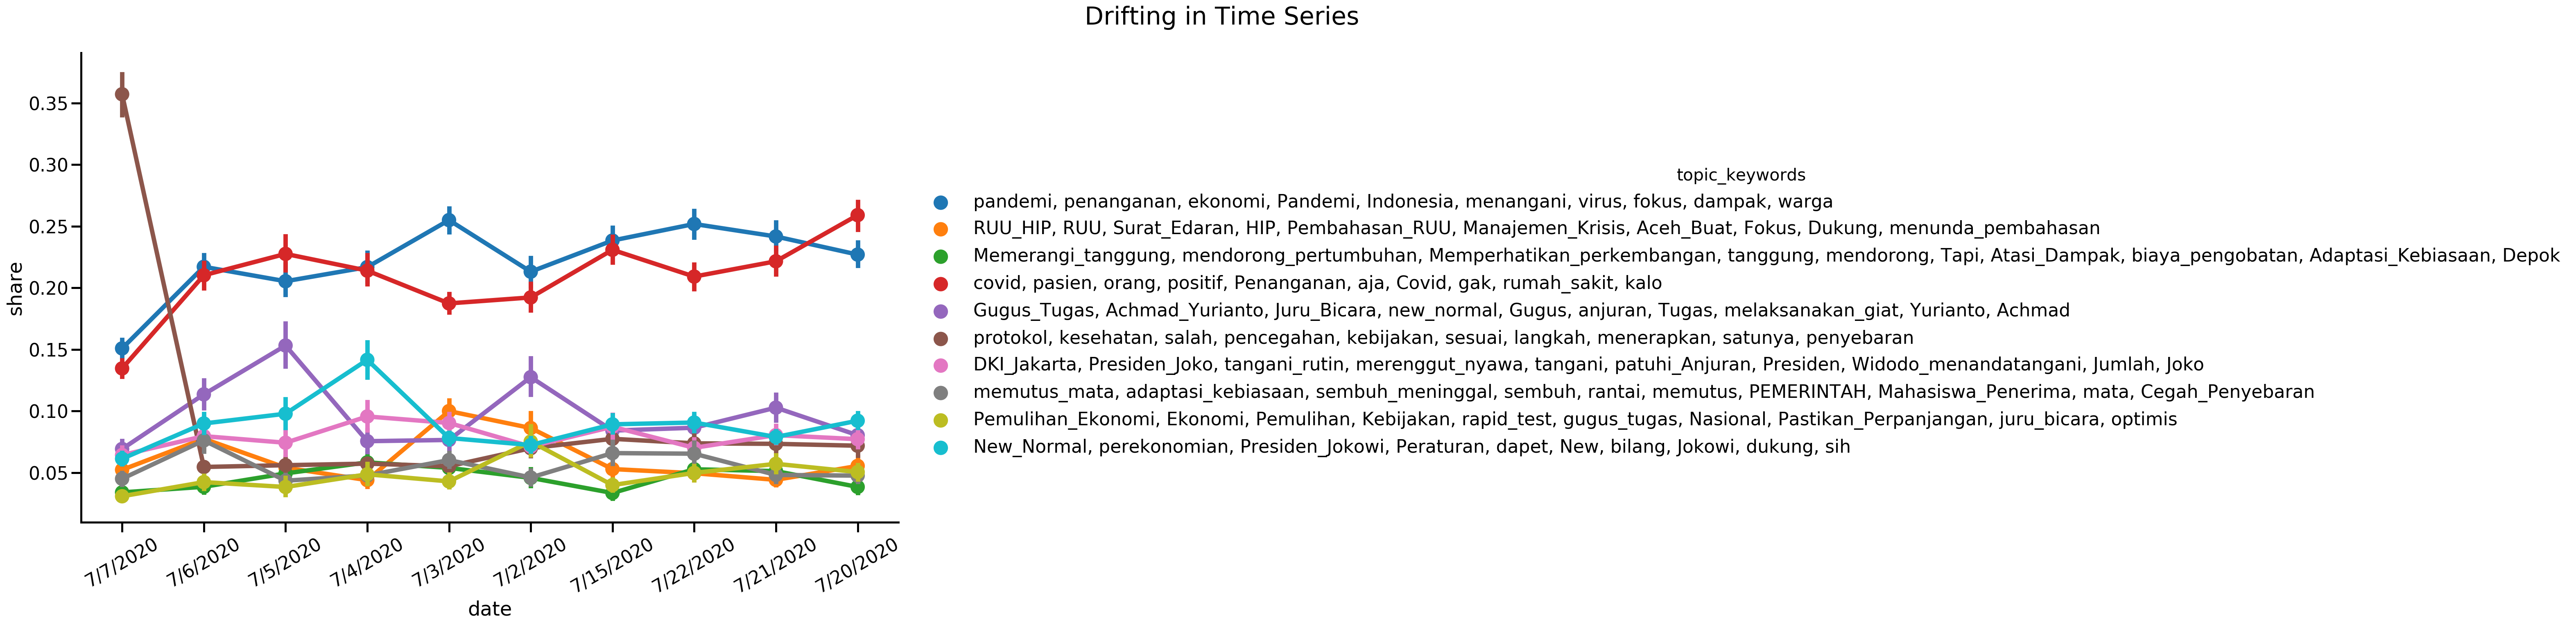

In [60]:
p = sns.factorplot(x="date", y='share', kind='point', hue_order=order, hue='topic_keywords',size=10, aspect=1.8, data=df)
p.fig.subplots_adjust(top=0.9)
p.fig.suptitle('Drifting in Time Series', fontsize=30)
p.set_xticklabels(rotation=30)
p

In [61]:
df.to_csv('D:/dataset/new_covid19_sentiment.csv')

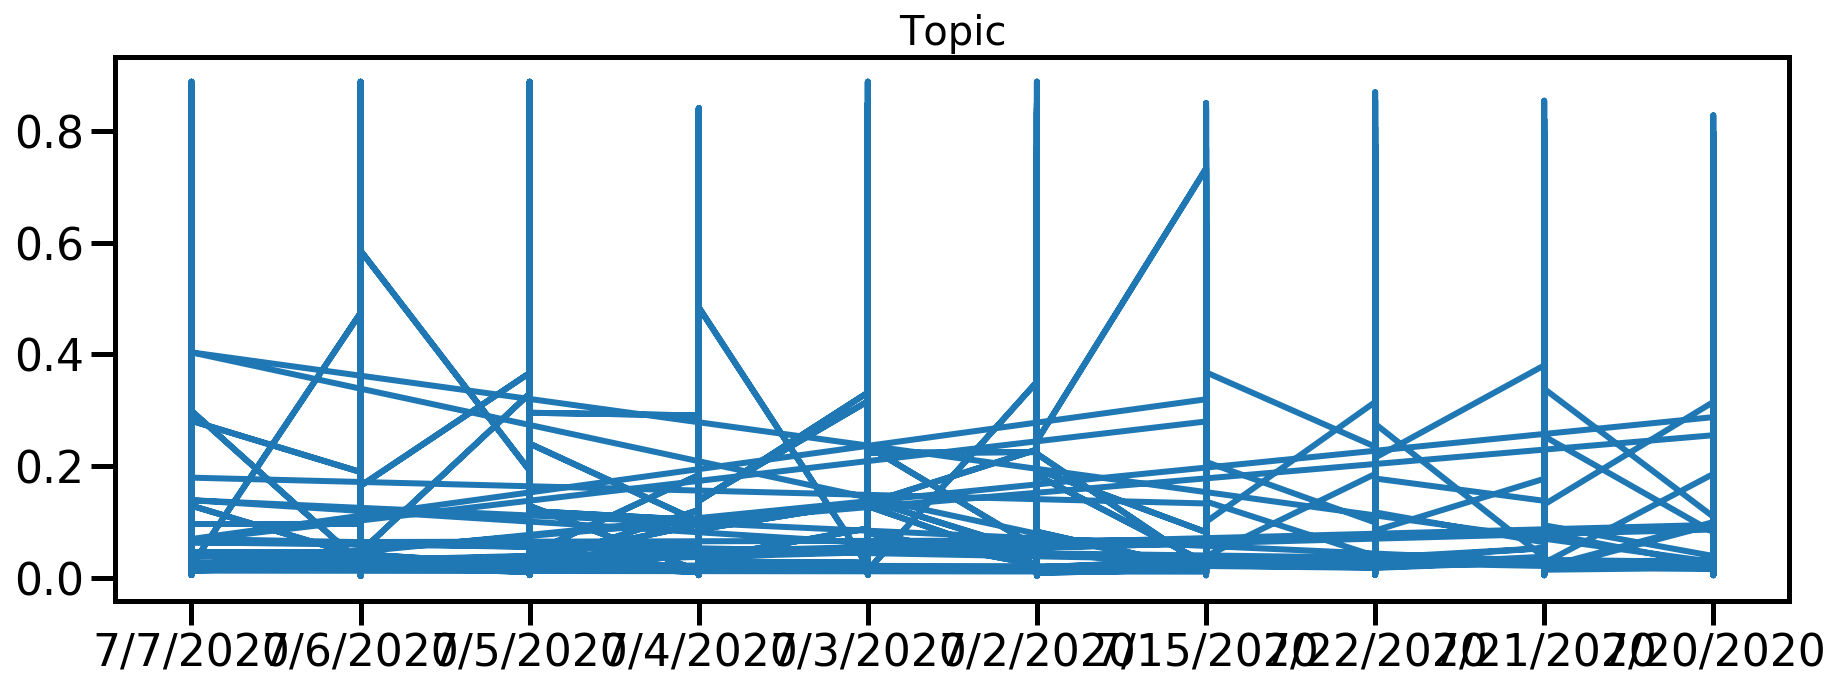

In [62]:
dates = df['date'].values
temp  = df['share'].values
 
plt.figure(figsize=(15,5))
plt.plot(dates, temp)
plt.title('Topic',
          fontsize=20);

In [63]:
from sklearn.model_selection import train_test_split
dates_train, dates_test, label_train, label_test = train_test_split(dates, temp, test_size=0.2)

In [64]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
 
tokenizer = Tokenizer(num_words=5000, oov_token='x')
tokenizer.fit_on_texts(dates_train) 
tokenizer.fit_on_texts(dates_test)
 
sekuens_latih = tokenizer.texts_to_sequences(dates_train)
sekuens_test = tokenizer.texts_to_sequences(dates_test)
 
padded_latih = pad_sequences(sekuens_latih) 
padded_test = pad_sequences(sekuens_test)

In [65]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [66]:
test_set = windowed_dataset(label_test, window_size=60, batch_size=100, shuffle_buffer=1000)
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [67]:
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mse"])
history = model.fit(test_set,epochs=5)

Epoch 1/5
186/186 [==============================] - 26s 142ms/step - loss: 0.0155 - mse: 0.0311
Epoch 2/5
186/186 [==============================] - 24s 131ms/step - loss: 0.0137 - mse: 0.0273
Epoch 3/5
186/186 [==============================] - 25s 132ms/step - loss: 0.0126 - mse: 0.0251
Epoch 4/5
186/186 [==============================] - 24s 131ms/step - loss: 0.0121 - mse: 0.0242
Epoch 5/5
186/186 [==============================] - 25s 136ms/step - loss: 0.0120 - mse: 0.0239


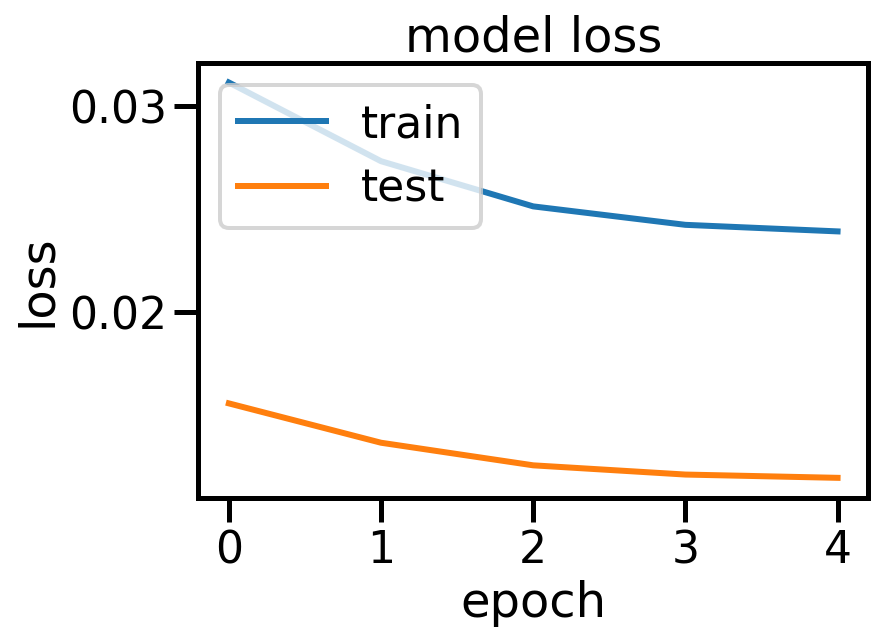

In [68]:
# visualisasi loss plot
plt.plot(history.history['mse'])
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [69]:
# Save the model in h5 format 
model.save("covid.h5")

In [73]:
# Load libraries
import flask
from keras.models import load_model

In [ ]:
# instantiate flask 
app = flask.Flask(__name__)


# load the model, and pass in the custom metric function
global graph
graph = tf.compat.v1.GraphDef()
model = tf.keras.models.load_model('covid.h5')

# define a predict function as an endpoint 
@app.route("/predict", methods=["GET","POST"])
def predict():
    data = {"success": False}

    params = flask.request.json
    if (params == None):
        params = flask.request.args

    # if parameters are found, return a prediction
    if (params != None):
        x=pd.DataFrame.from_dict(params, orient='index').transpose()
        with graph.as_default():
            data["prediction"] = str(model.predict(x)[0][0])
            data["success"] = True

    # return a response in json format 
    return flask.jsonify(data)    

# start the flask app, allow remote connections 
app.run(host='0.0.0.0')

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on all addresses.
 * Running on http://192.168.43.38:5000/ (Press CTRL+C to quit)
